In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import numpy as np

import mysql.connector as sql
from sqlalchemy import create_engine

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from sklearn.ensemble import StackingRegressor

In [13]:
mf_data=pd.read_csv("comprehensive_mutual_funds_data.csv")
mf_data.head()

scheme_name  min_sip  min_lumpsum  \
0  Aditya Birla SL Active Debt Multi-Mgr FoF-Dir ...      100          100   
1                     Aditya Birla SL Arbitrage Fund     1000         1000   
2     Aditya Birla SL Asset Allocator FoF-Dir Growth     1000         1000   
3   Aditya Birla SL Bal Bhavishya Yojna – Dir Growth      500         1000   
4            Aditya Birla SL Balanced Advantage Fund      100          100   

   expense_ratio  fund_size_cr  fund_age_yr        fund_manager sortino  \
0           0.27          10.0           10      Kaustubh Gupta    0.32   
1           0.36        4288.0           10    Lovelish Solanki    1.33   
2           0.53         157.0           10  Vinod Narayan Bhat    3.44   
3           0.76         637.0            4         Atul Penkar    2.18   
4           0.61        6386.0           10        Mohit Sharma    3.69   

   alpha     sd  beta sharpe  risk_level                           amc_name  \
0   2.24   9.39  0.01   0.24           3  Aditya Birla Sun Life Mutual Fund   
1   1.53   0.72  0.56    1.1           1  Aditya Birla Sun Life Mutual Fund   
2   2.67  10.58  0.67   1.42           5  Aditya Birla Sun Life Mutual Fund   
3  -6.37  14.99  0.85    0.9           6  Aditya Birla Sun Life Mutual Fund   
4   1.99  10.38  0.68   1.39           6  Aditya Birla Sun Life Mutual Fund   

   rating           category                                    sub_category  \
0       3              Other                                   FoFs Domestic   
1       3             Hybrid                          Arbitrage Mutual Funds   
2       3              Other                                   FoFs Domestic   
3       2  Solution Oriented                                 Childrens Funds   
4       4             Hybrid  Dynamic Asset Allocation or Balanced Advantage   

   returns_1yr  returns_3yr  returns_5yr  
0          4.0          6.5          6.9  
1          5.6          4.8          5.5  
2          2.0         18.9          9.7  
3         -0.7         17.1          NaN  
4          4.5         18.6          9.7

In [14]:
mf_data.shape

(814, 20)

In [15]:
mf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   scheme_name    814 non-null    object 
 1   min_sip        814 non-null    int64  
 2   min_lumpsum    814 non-null    int64  
 3   expense_ratio  814 non-null    float64
 4   fund_size_cr   814 non-null    float64
 5   fund_age_yr    814 non-null    int64  
 6   fund_manager   814 non-null    object 
 7   sortino        814 non-null    object 
 8   alpha          814 non-null    object 
 9   sd             814 non-null    object 
 10  beta           814 non-null    object 
 11  sharpe         814 non-null    object 
 12  risk_level     814 non-null    int64  
 13  amc_name       814 non-null    object 
 14  rating         814 non-null    int64  
 15  category       814 non-null    object 
 16  sub_category   814 non-null    object 
 17  returns_1yr    814 non-null    float64
 18  returns_3y

In [16]:
nulls=pd.DataFrame([mf_data.isnull().sum(),(mf_data.isnull().sum()/mf_data.shape[0])*100]).transpose()
nulls.rename(columns={0:"number of nulls",1:"percentage of nulls"},inplace=True)
nulls

number of nulls  percentage of nulls
scheme_name                0.0             0.000000
min_sip                    0.0             0.000000
min_lumpsum                0.0             0.000000
expense_ratio              0.0             0.000000
fund_size_cr               0.0             0.000000
fund_age_yr                0.0             0.000000
fund_manager               0.0             0.000000
sortino                    0.0             0.000000
alpha                      0.0             0.000000
sd                         0.0             0.000000
beta                       0.0             0.000000
sharpe                     0.0             0.000000
risk_level                 0.0             0.000000
amc_name                   0.0             0.000000
rating                     0.0             0.000000
category                   0.0             0.000000
sub_category               0.0             0.000000
returns_1yr                0.0             0.000000
returns_3yr               21.0             2.579853
returns_5yr              167.0            20.515971

In [17]:
mf_data["returns_3yr"].fillna(mf_data["returns_3yr"].mean(),inplace=True)
mf_data["returns_5yr"].fillna(mf_data["returns_5yr"].mean(),inplace=True)

In [18]:
mf_data.describe()

min_sip   min_lumpsum  expense_ratio  fund_size_cr  fund_age_yr  \
count   814.000000    814.000000     814.000000    814.000000   814.000000   
mean    528.500000   3047.468059       0.713231   3812.854214     8.319410   
std     369.184517   2514.619513       0.482161   7181.479475     2.640622   
min       0.000000      0.000000       0.000000      2.380000     1.000000   
25%     150.000000    500.000000       0.310000    175.250000     6.000000   
50%     500.000000   5000.000000       0.615000    940.500000    10.000000   
75%    1000.000000   5000.000000       1.030000   3819.000000    10.000000   
max    2000.000000  25000.000000       2.590000  57052.000000    17.000000   

       risk_level      rating  returns_1yr  returns_3yr  returns_5yr  
count  814.000000  814.000000   814.000000   814.000000   814.000000  
mean     4.400491    2.641278     3.921376    18.525347     9.490726  
std      1.814741    1.463476     6.675502    11.951071     3.310660  
min      1.000000    0.000000   -19.700000     3.300000    -4.100000  
25%      3.000000    2.000000     1.500000     6.300000     7.100000  
50%      6.000000    3.000000     4.400000    18.525347     9.490726  
75%      6.000000    4.000000     5.600000    27.000000    11.500000  
max      6.000000    5.000000   130.800000    71.400000    23.200000

In [19]:
mf_data.nunique()

scheme_name      789
min_sip           10
min_lumpsum       11
expense_ratio    177
fund_size_cr     693
fund_age_yr       14
fund_manager     260
sortino          385
alpha            540
sd               581
beta             162
sharpe           217
risk_level         6
amc_name          39
rating             6
category           5
sub_category      38
returns_1yr      210
returns_3yr      305
returns_5yr      148
dtype: int64

In [20]:
cat_col=[]
num_col=[]
for col in mf_data:
    if mf_data[col].nunique()<=40:
        cat_col.append(col)
    else:
        num_col.append(col)

In [21]:
print("categorical columns :",cat_col)
print("Numerical columns :",num_col)

categorical columns : ['min_sip', 'min_lumpsum', 'fund_age_yr', 'risk_level', 'amc_name', 'rating', 'category', 'sub_category']
Numerical columns : ['scheme_name', 'expense_ratio', 'fund_size_cr', 'fund_manager', 'sortino', 'alpha', 'sd', 'beta', 'sharpe', 'returns_1yr', 'returns_3yr', 'returns_5yr']


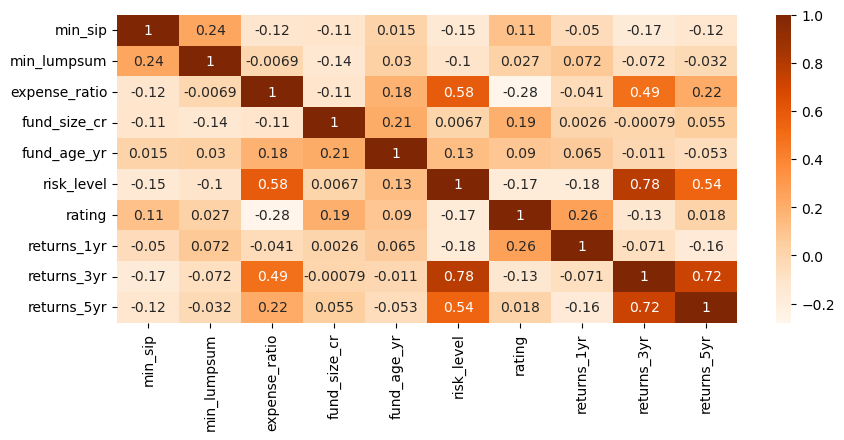

In [22]:
plt.figure(figsize=(10,4))
sns.heatmap(mf_data.corr(),annot=True,cmap="Oranges")
plt.show()

In [12]:
def bar_pie(*s):
    for col in s:
        value_counts=mf_data[col].value_counts()
        
        if col in ["amc_name","sub_category"]:
            fig,ax=plt.subplots(1,2,figsize=(20,10))
            sns.barplot(y=value_counts.index,x=value_counts.values,ax=ax[0],orient="h")
        else:
            fig,ax=plt.subplots(1,2,figsize=(12,4))
            sns.barplot(value_counts.index,value_counts.values,ax=ax[0])
        ax[0].set_title(f"count of {col} in each type")
        ax[0].set_xlabel(f"{col}")
        ax[0].set_ylabel(f"frequency of {col}")

        per=mf_data[col].value_counts(normalize=True)*100
        ax[1].pie(per.values,labels=per.index,autopct="%1.1f%%")
        ax[1].set_title(f"percentage of {col}")

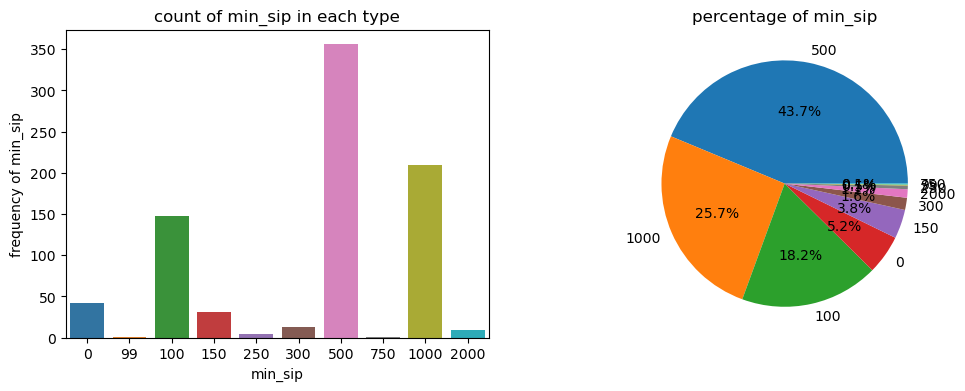

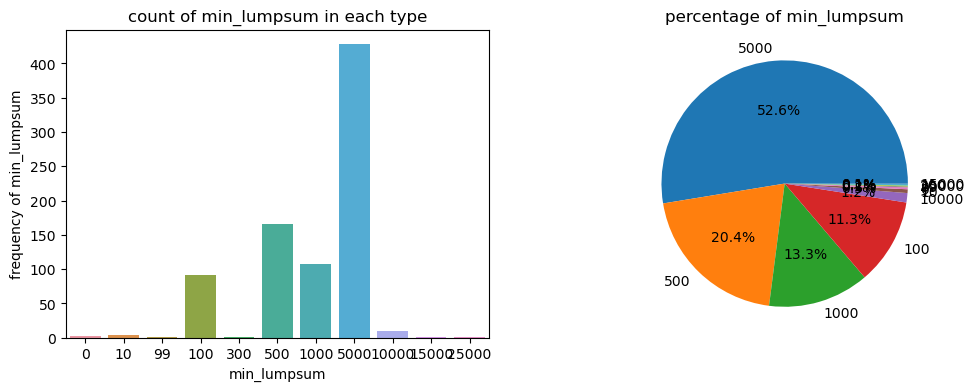

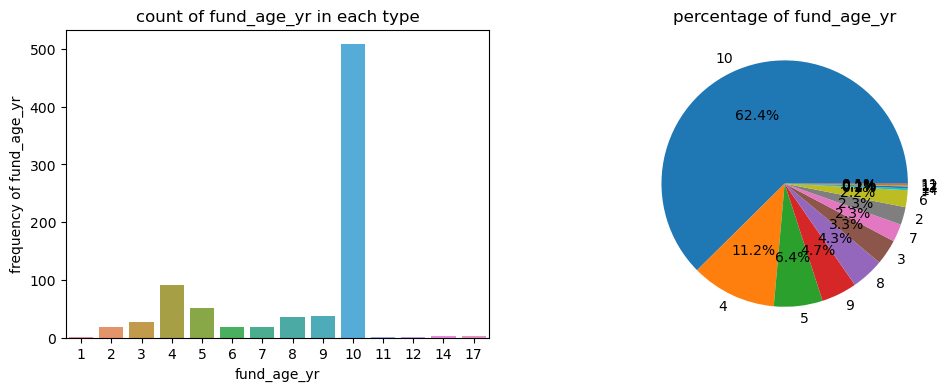

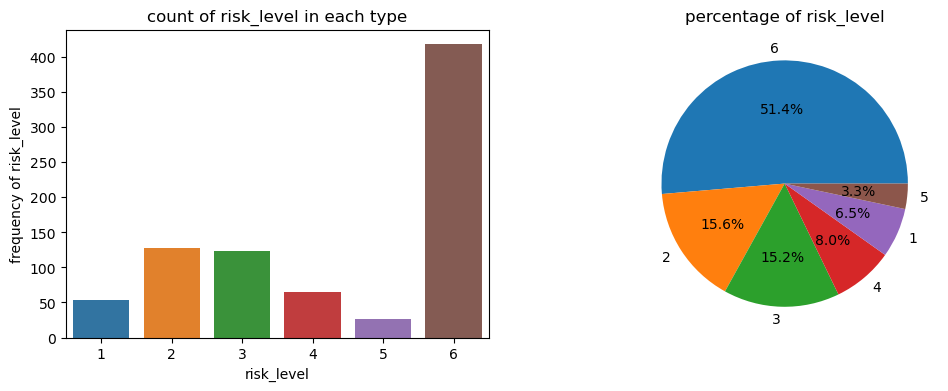

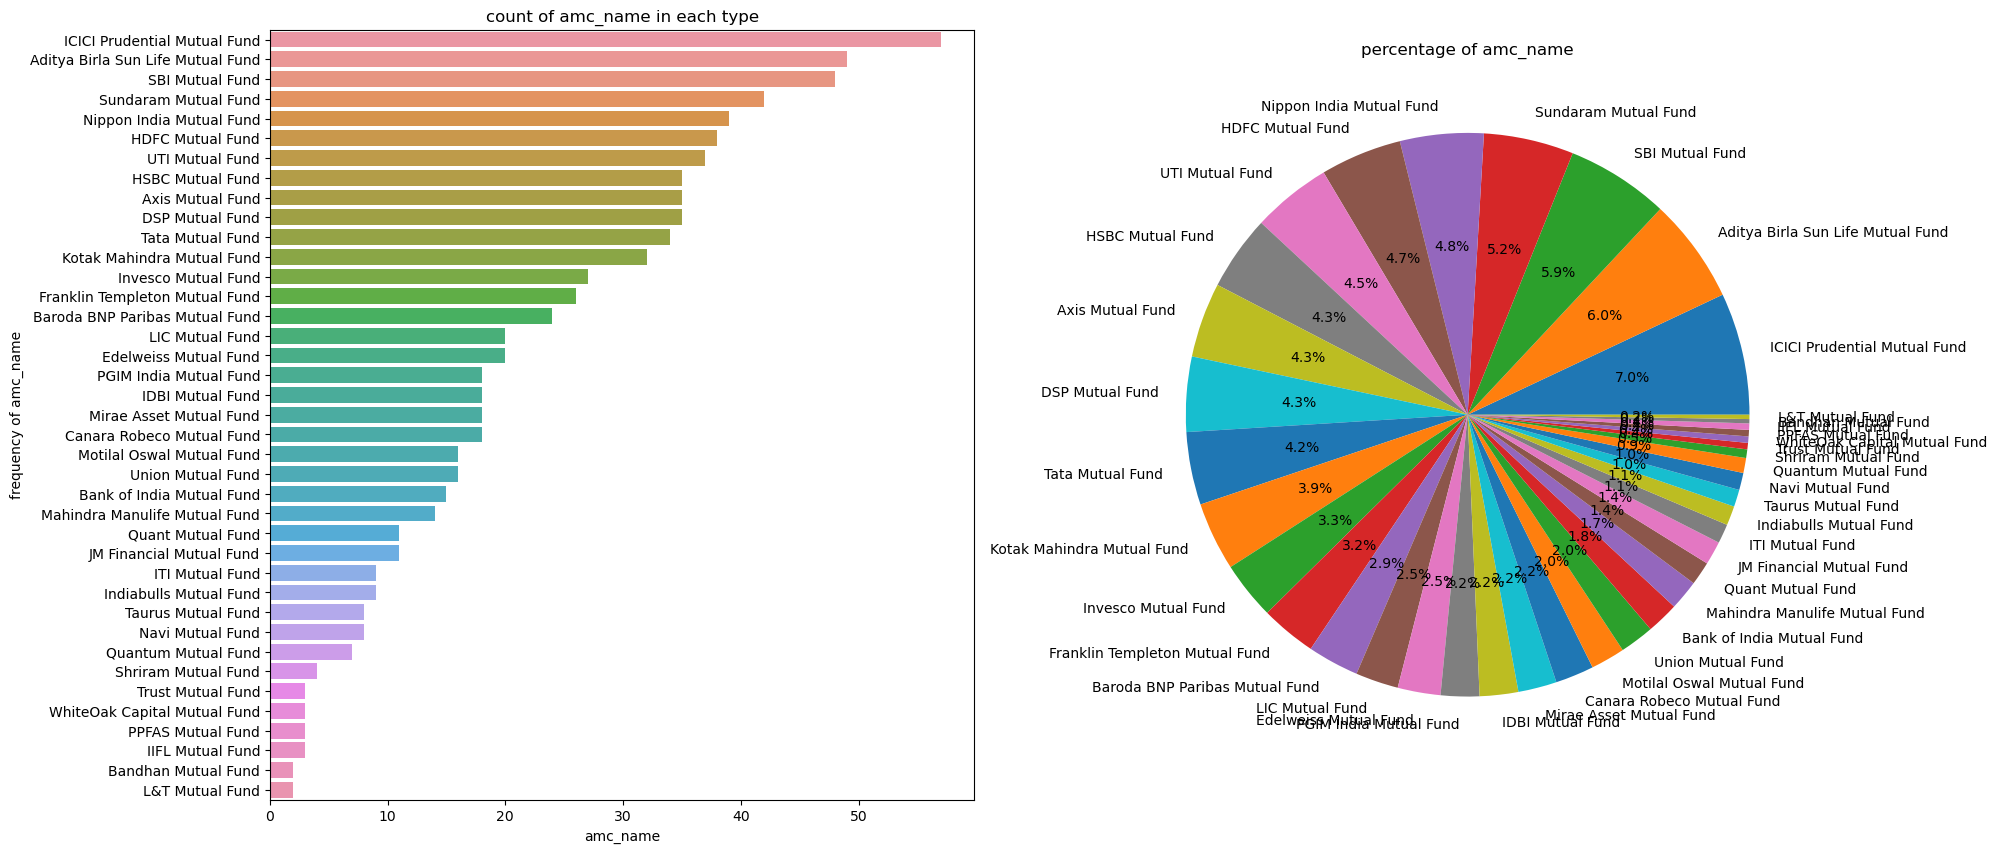

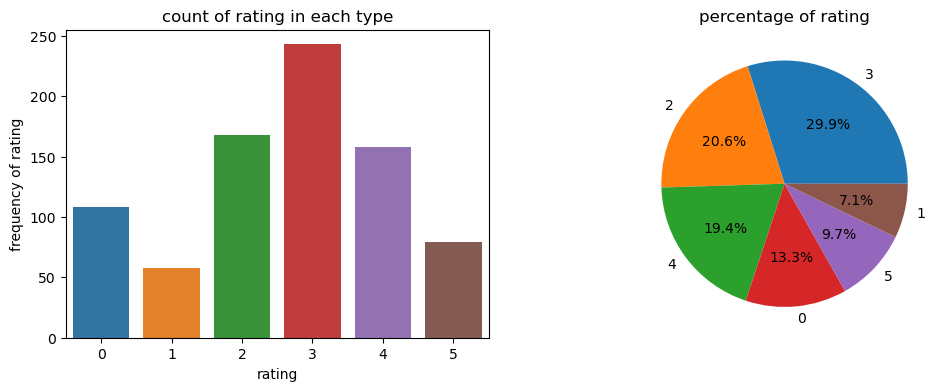

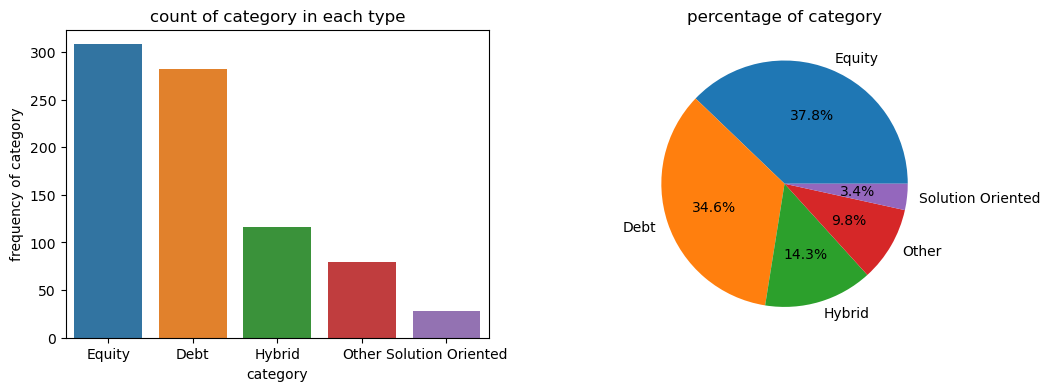

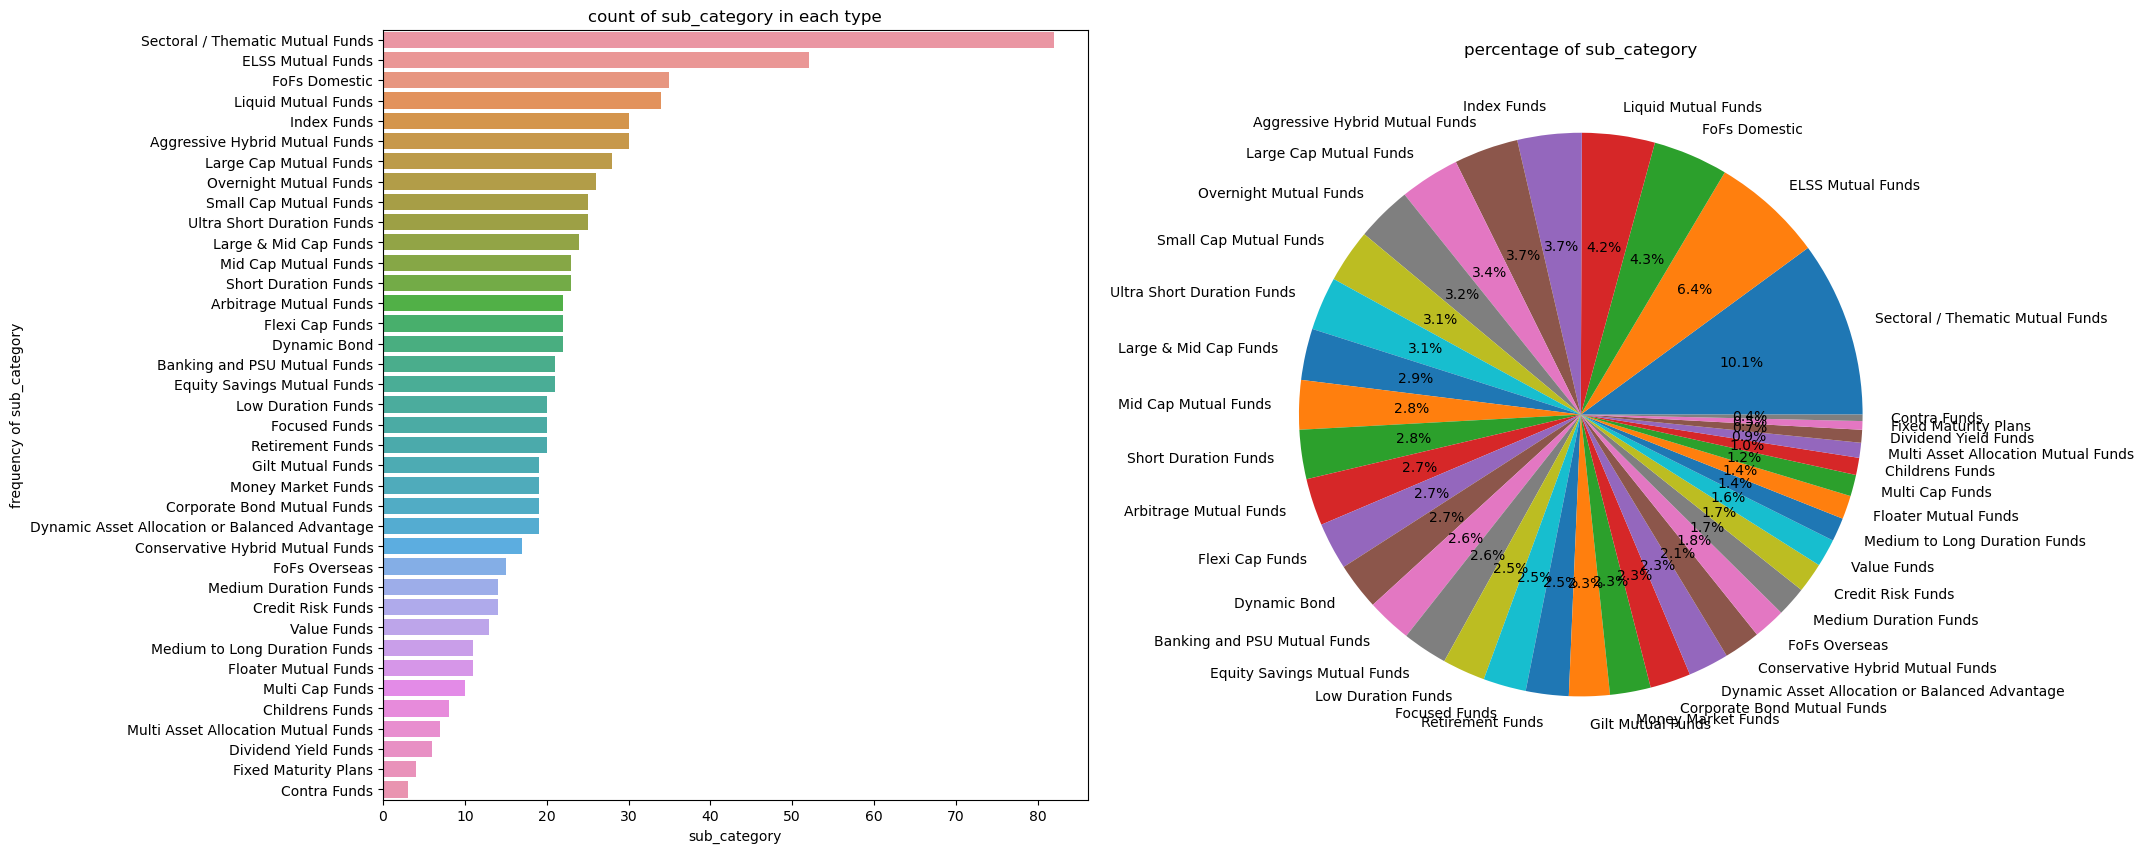

In [13]:
bar_pie('min_sip',
 'min_lumpsum',
 'fund_age_yr',
 'risk_level',
 'amc_name',
 'rating',
 'category',
 'sub_category')

1. Most of the person prefer minimum sip 500 and followed by 1000.
2. Most of the person prefer minimum lumpsum 1000 and followed by 500.
3. 62 % mf companies in data have their age 10.
4. half of companies in data have maximum risk level.
5. 30% of the funds have rating 3.Most of the ratings are 2 to 4.
6. more than 70% of the funds are either Equity or Debt fund.

In [14]:
col_list=["sortino","alpha","sd","beta","sharpe"]
for col in col_list:
    mf_data[col][mf_data[col]=="-"]=None
    mf_data[col]=mf_data[col].astype(float)
    mf_data[col].fillna(mf_data[col].mean(),inplace=True)

In [15]:
def hist_box(*s):
    for col in s:
        values=mf_data[col].values
        fig,ax=plt.subplots(1,2,figsize=(15,4))
        sns.histplot(values,bins=20,ax=ax[0])
        ax[0].set_title(f"Distribution of {col} using histogram")
        ax[0].set_xlabel(f"{col}")
        ax[0].set_ylabel(f"frequency of {col}")


        sns.boxplot(y=mf_data[col],ax=ax[1])
        ax[1].set_title(f"Distribution using boxplot of {col}")

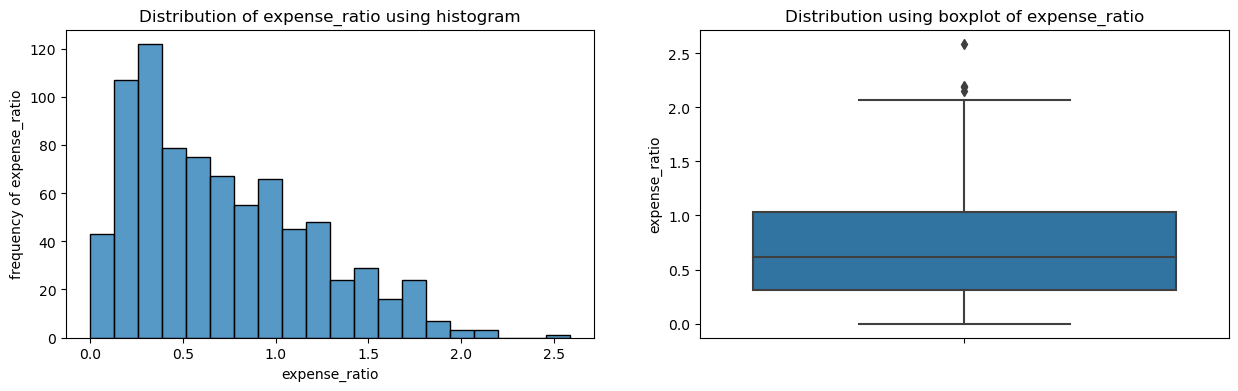

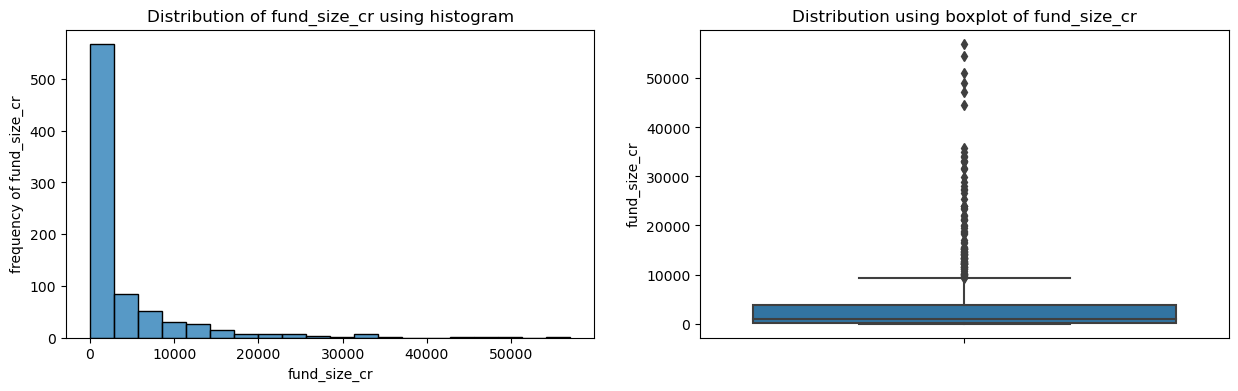

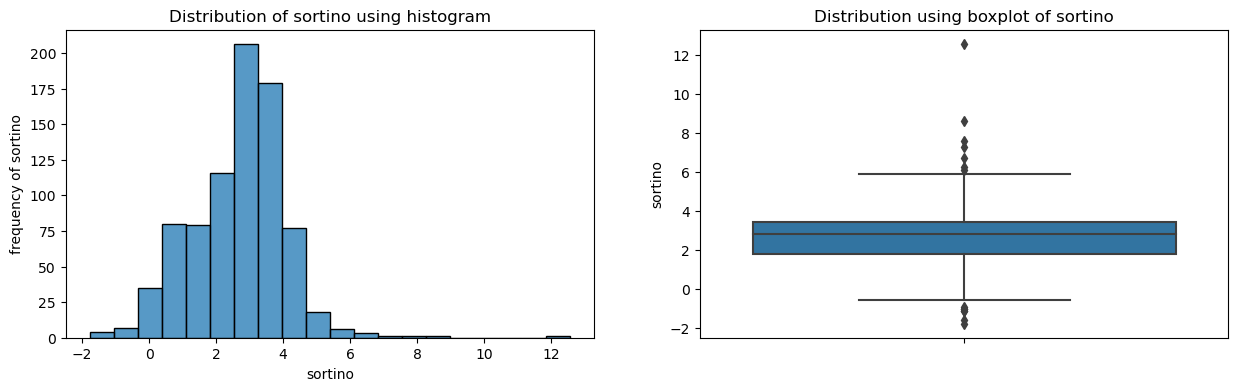

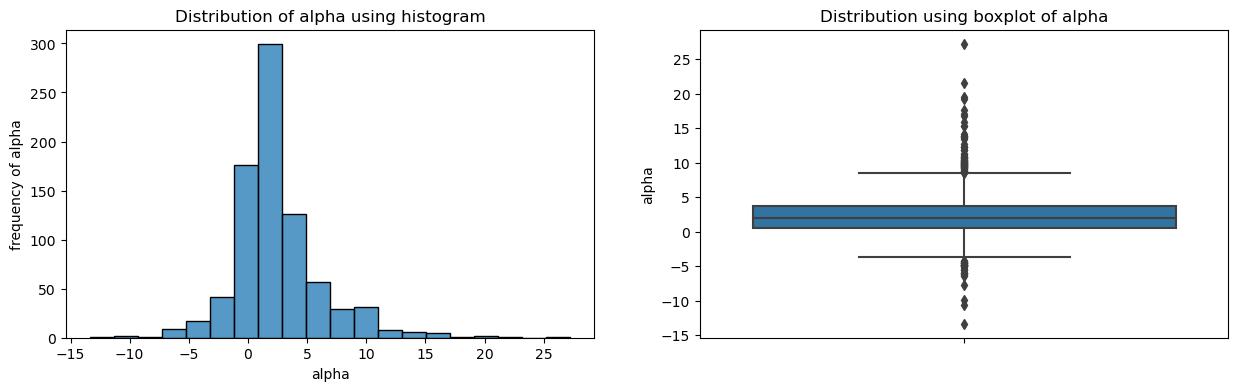

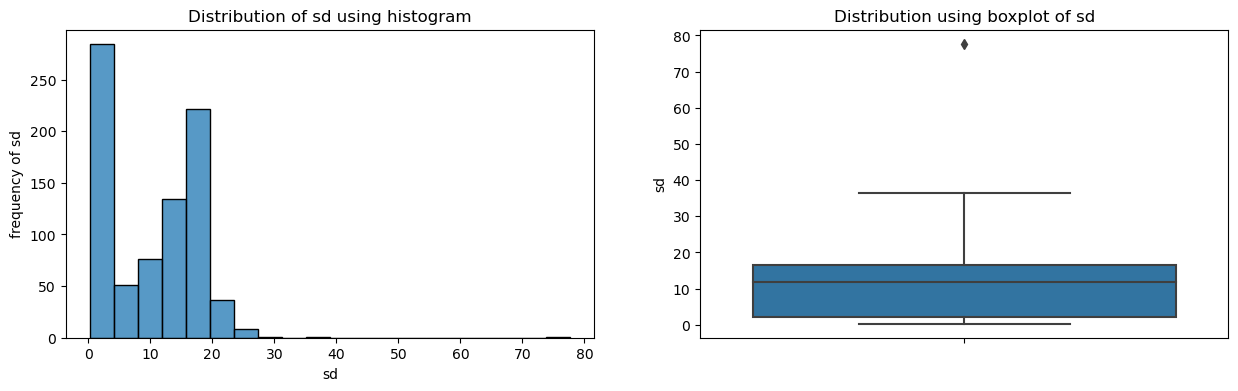

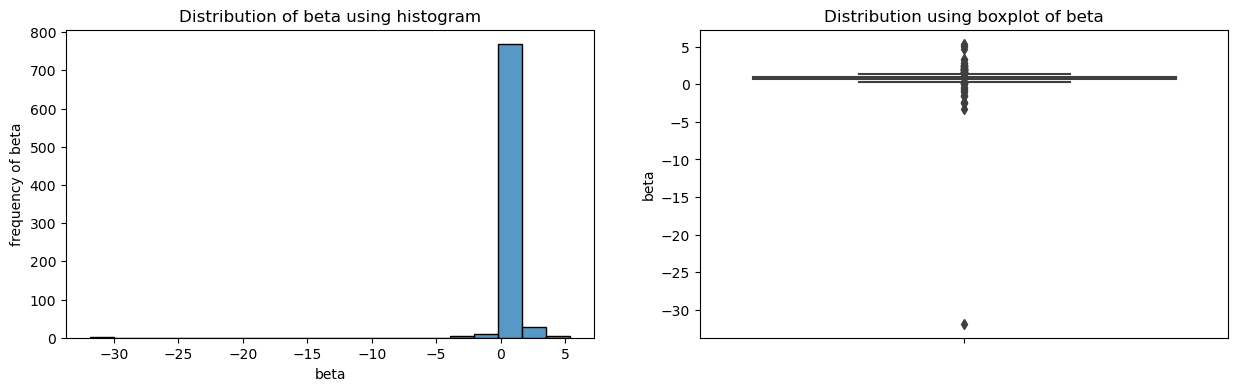

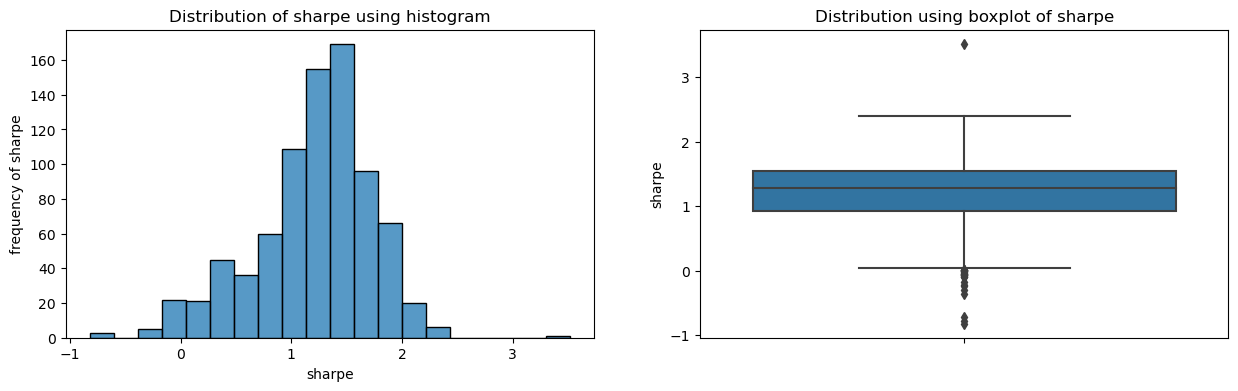

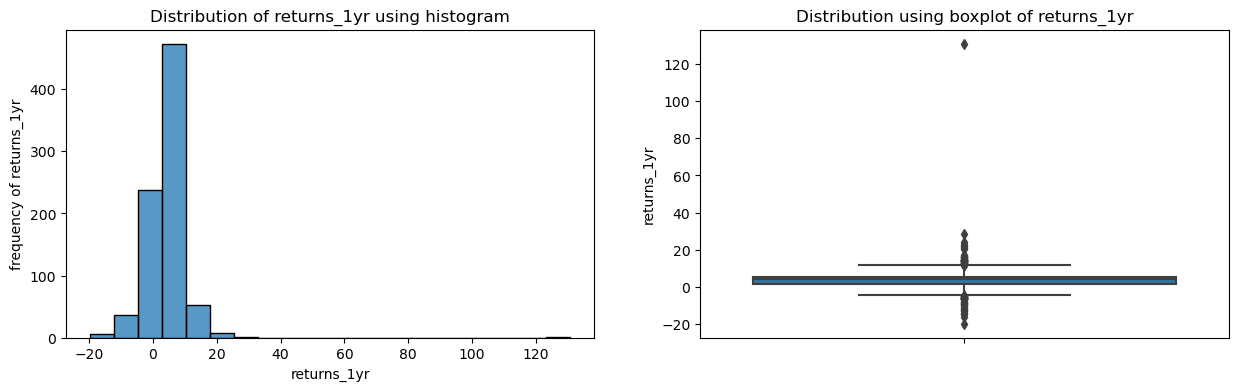

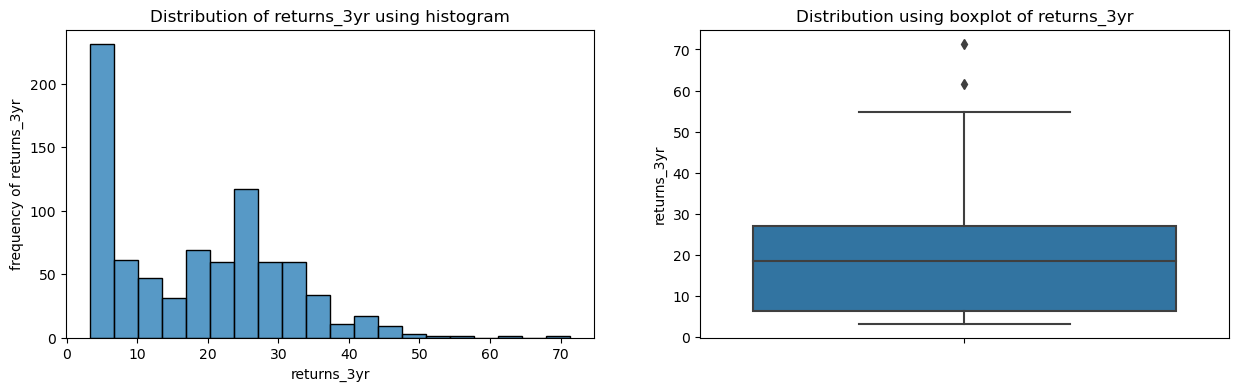

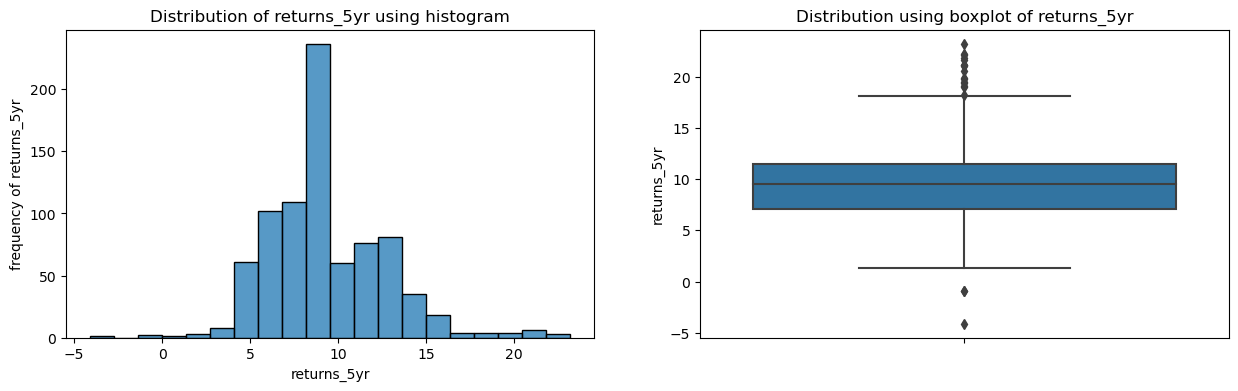

In [16]:
hist_box(
 'expense_ratio',
 'fund_size_cr','sortino','alpha',
 'sd',
 'beta',
 'sharpe',
 'returns_1yr',
 'returns_3yr',
 'returns_5yr')

## Outliers treatment

In [17]:
mf_data["fund_size_cr"][mf_data["fund_size_cr"]>30000]=mf_data["fund_size_cr"].mean()

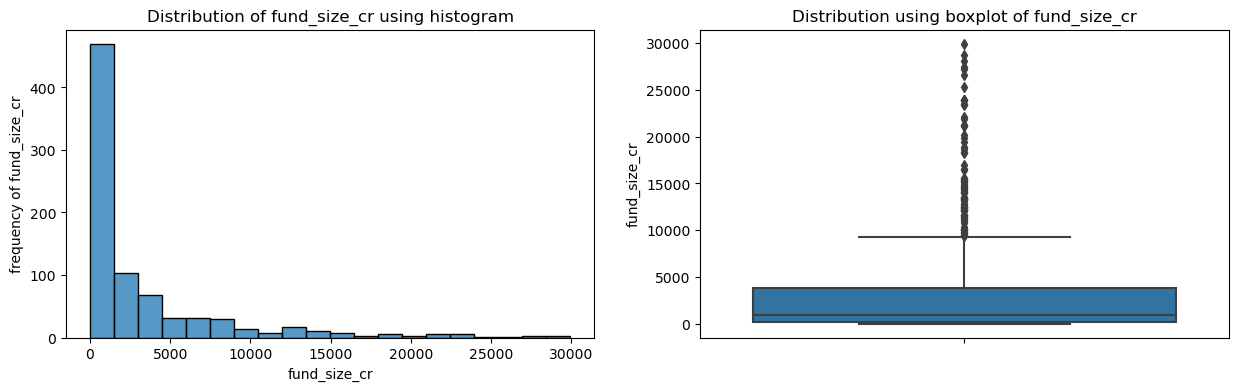

In [18]:
hist_box('fund_size_cr')

In [19]:
mf_data["sortino"][mf_data["sortino"]>10]=mf_data["sortino"].mean()

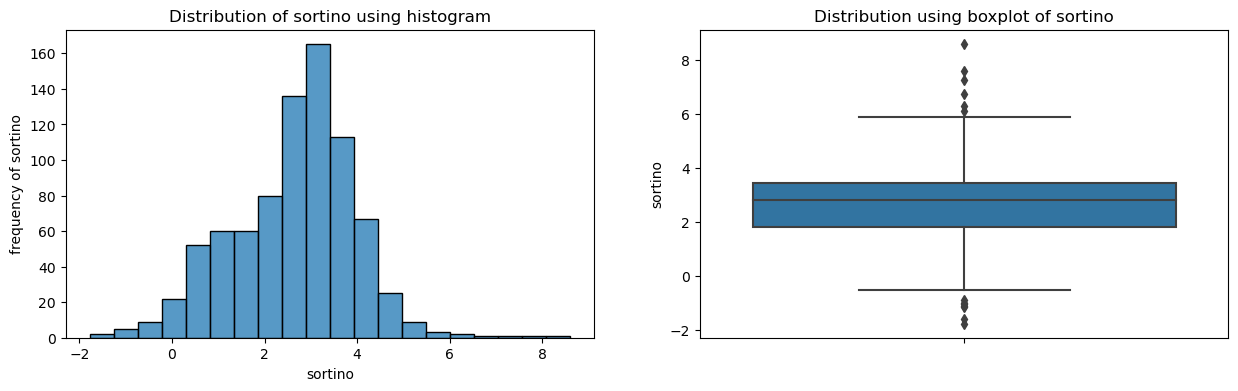

In [20]:
hist_box('sortino')

In [21]:
mf_data["sd"][mf_data["sd"]>50]=mf_data["sd"].mean()

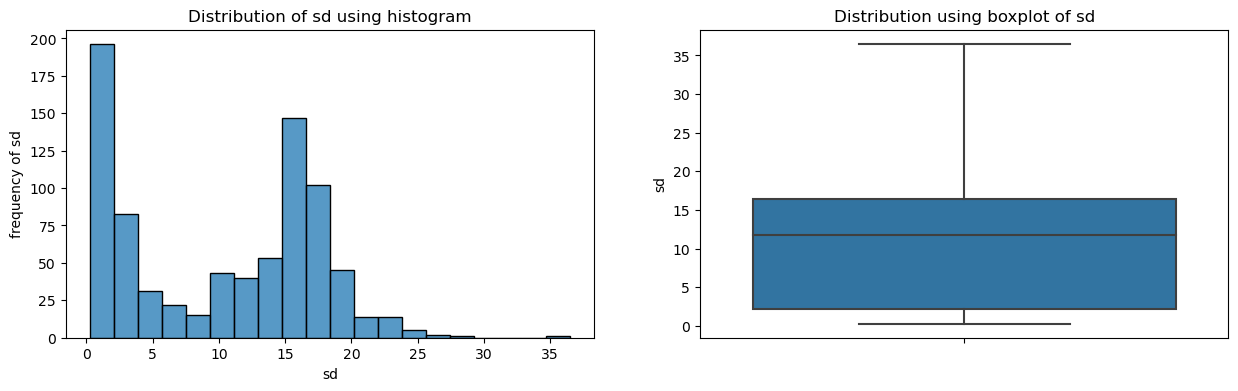

In [22]:
hist_box('sd')

In [23]:
mf_data["beta"][(mf_data["beta"]<-1)|(mf_data["beta"]>3)]=mf_data["beta"].mean()

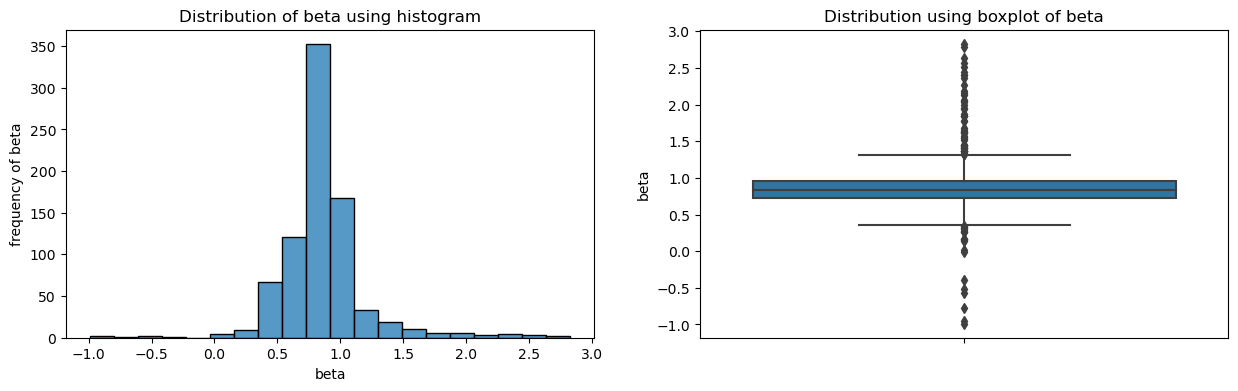

In [24]:
hist_box('beta')

In [25]:
mf_data["returns_1yr"][mf_data["returns_1yr"]>40]=mf_data["returns_1yr"].mean()

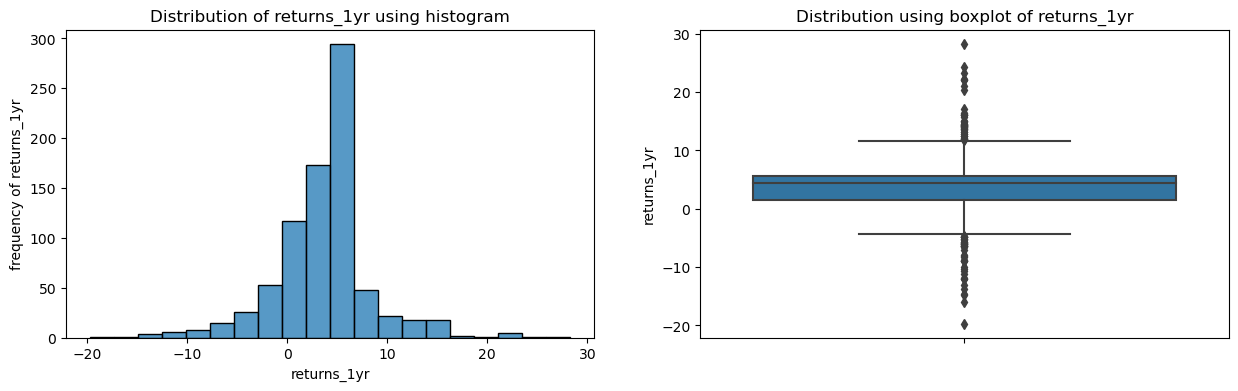

In [26]:
hist_box('returns_1yr')

1. Most of mf companies have expence ratio around 0.3 to 1.
2. 5 year return should be expected in between 0 to 5
3. 3 year return should be expected in between 5 to 30.
4. 5 year return should be expected in between 5 to 15.

## Bivariate

In [27]:
def bi_rat(*s):
    fig,ax=plt.subplots(4,3,figsize=(15,20))
    ax=ax.ravel()
    i=0
    for col in s:
        sns.boxplot("rating",col,data=mf_data[mf_data["rating"]!=0],ax=ax[i])
        ax[i].set_title(f"rating wise {col}")
        i+=1
    plt.show()

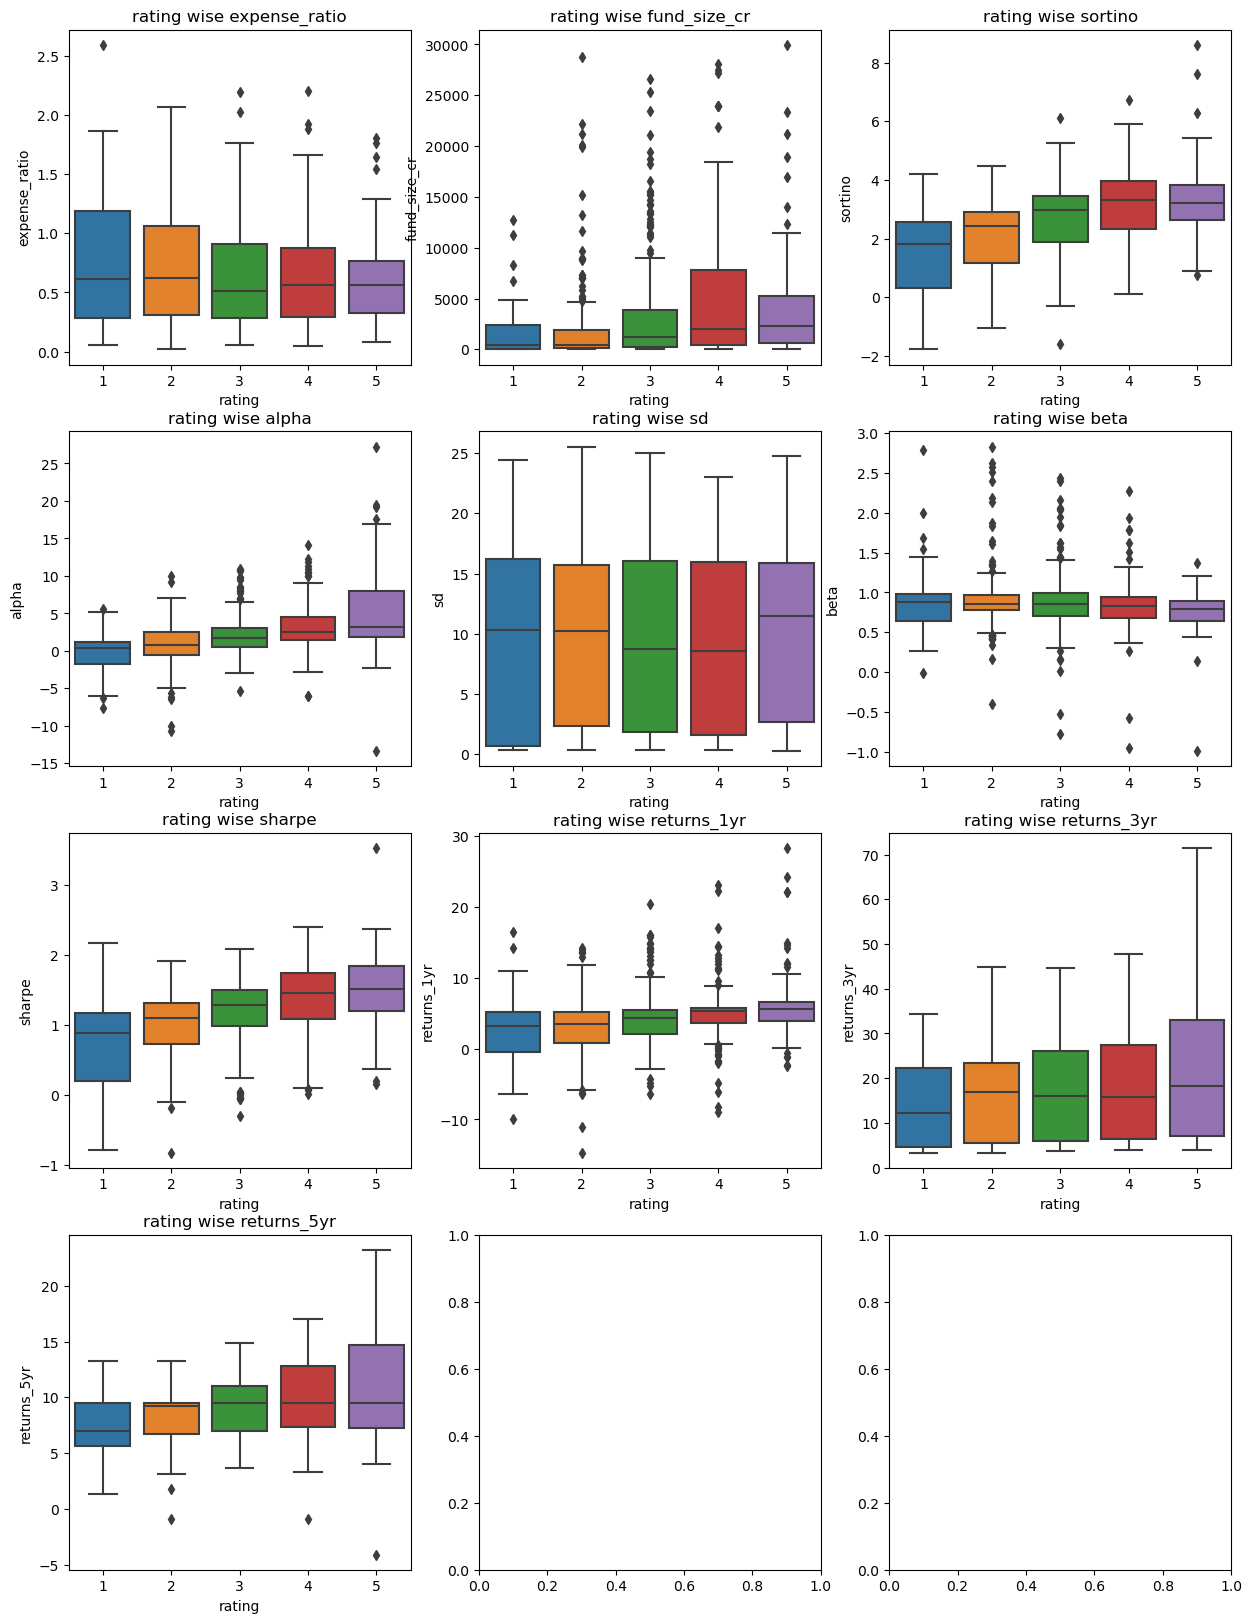

In [28]:
bi_rat(
 'expense_ratio',
 'fund_size_cr','sortino','alpha',
 'sd',
 'beta',
 'sharpe',
 'returns_1yr',
 'returns_3yr',
 'returns_5yr')

1. companies with high expense_ratio have chances of less ratings
2. more the the fund size more will be rating.
3. more the sortino,alpha,sharpe more will be rating.
4. high rating fund always return good in any years.

In [29]:
def bi_risk(*s):
    fig,ax=plt.subplots(4,3,figsize=(15,20))
    ax=ax.ravel()
    i=0
    for col in s:
        sns.boxplot("risk_level",col,data=mf_data,ax=ax[i])
        ax[i].set_title(f"risk_level wise {col}")
        i+=1
    plt.show()

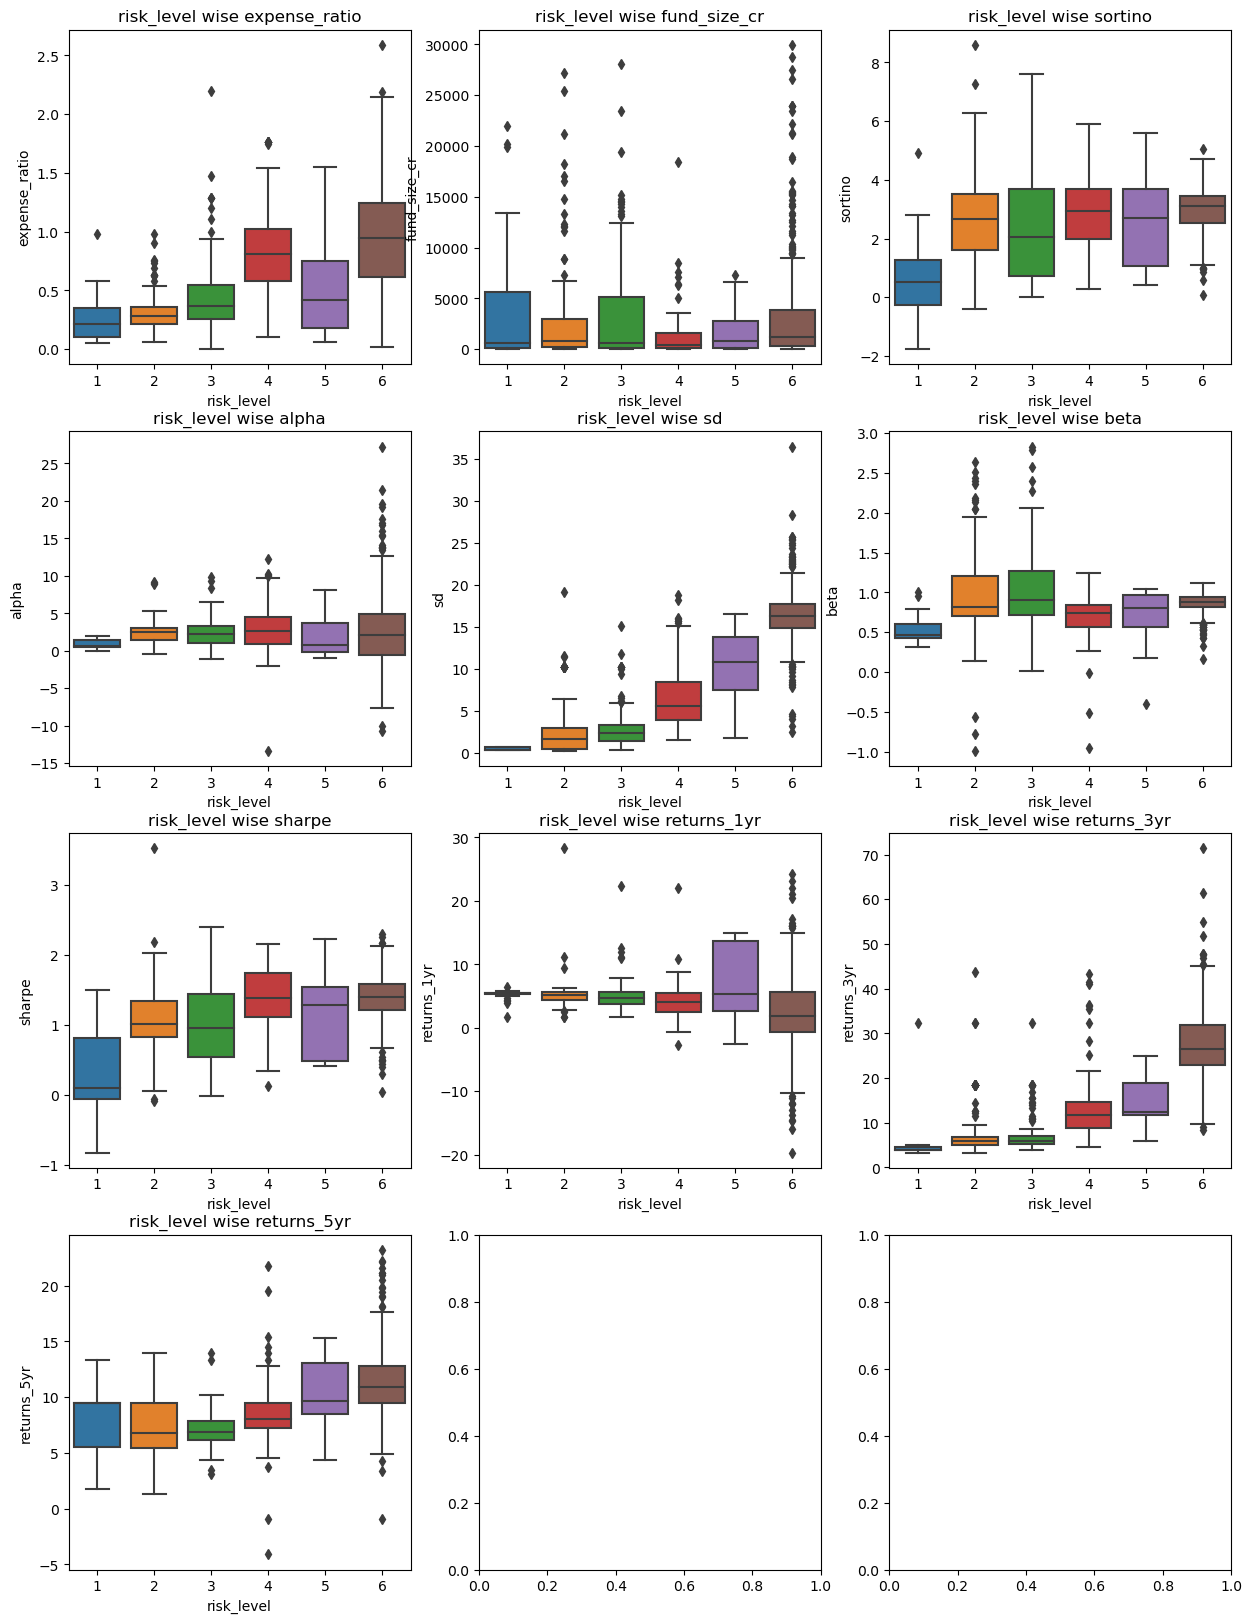

In [30]:
bi_risk(
 'expense_ratio',
 'fund_size_cr','sortino','alpha',
 'sd',
 'beta',
 'sharpe',
 'returns_1yr',
 'returns_3yr',
 'returns_5yr')

1. expense ratio will be high for higher risk levels.
2. sd is completely related to risk level, when sd is high risk level will also be high.
3. return of 1 year and risk level have very minor opposite corelation.
4. return of 3 years is will be very good if risk level is high.
4. return of 4 years is will be little good if risk level is high.

In [31]:
def bi_cat(*s):
    fig,ax=plt.subplots(4,3,figsize=(20,20))
    ax=ax.ravel()
    i=0
    for col in s:
        sns.boxplot("category",col,data=mf_data,ax=ax[i])
        ax[i].set_title(f"category wise {col}")
        i+=1
    plt.show()

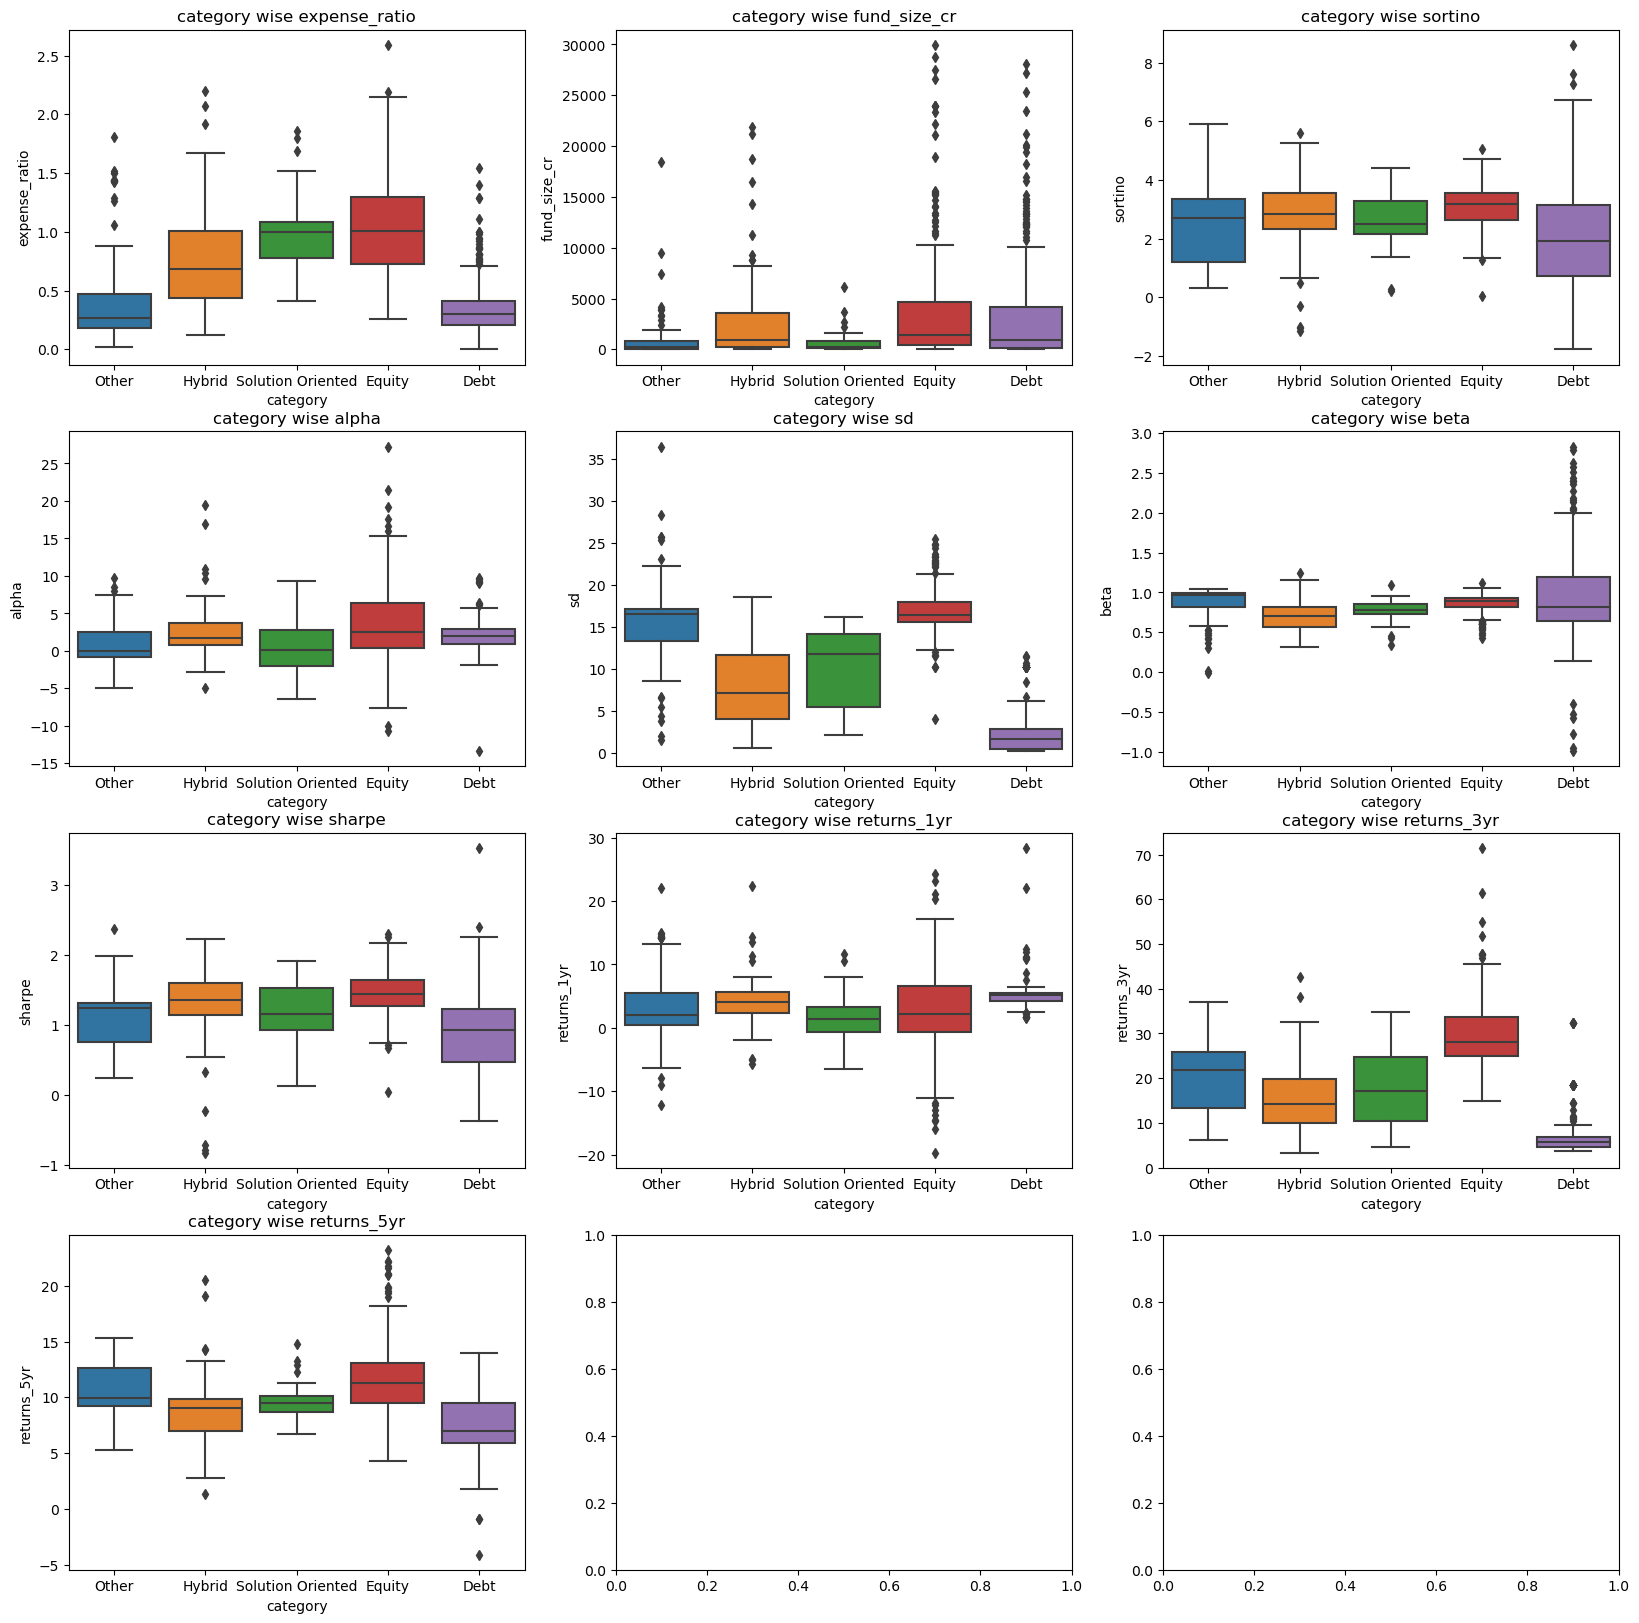

In [32]:
bi_cat(
 'expense_ratio',
 'fund_size_cr','sortino','alpha',
 'sd',
 'beta',
 'sharpe',
 'returns_1yr',
 'returns_3yr',
 'returns_5yr')

1. Equity fund have higher expense ration followed by Solution oriented fund, where expense ratio of debt fund is less.
2. sd in Equity fund is high and for debt fund it is less.
3. in 1 year all category will give same returns.
4. in 3 years Equity fund gives best return, whether debt fund give very bad returns.
5. in 5 years also Equity fund gives best and Debt fund gives less but better than year 3.

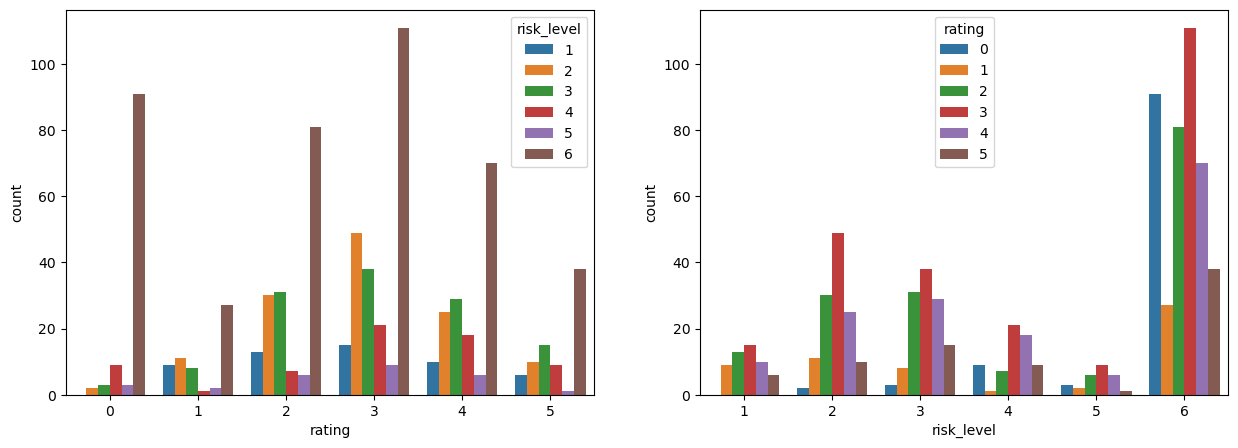

In [33]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax=ax.ravel()
sns.countplot("rating",hue="risk_level",data=mf_data,ax=ax[0])
sns.countplot("risk_level",hue="rating",data=mf_data,ax=ax[1])
plt.show()

1. risk level 6 is high for every ratings, since more than 50% of the funds have risk level 6.
2. in every risk level most of ratings is 3.

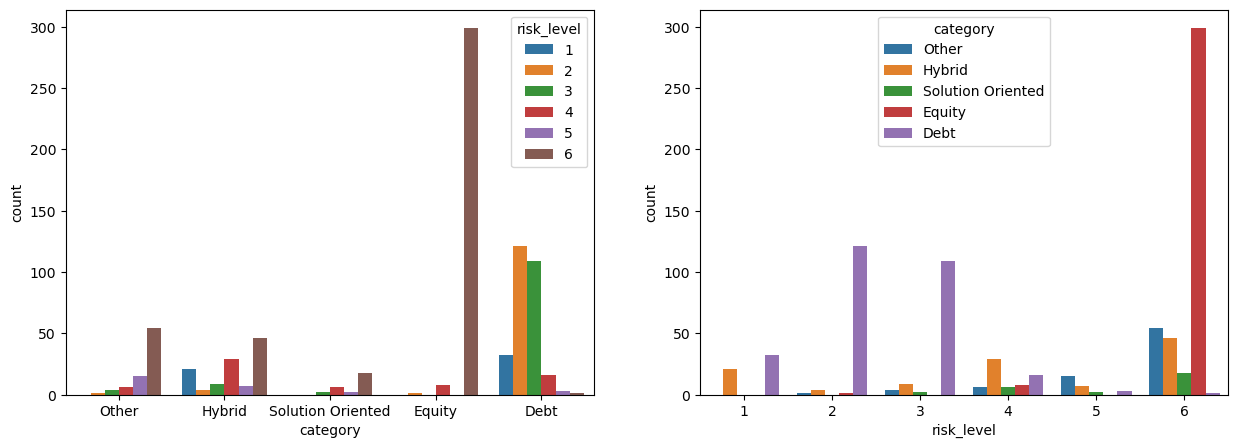

In [34]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax=ax.ravel()
sns.countplot("category",hue="risk_level",data=mf_data,ax=ax[0])
sns.countplot("risk_level",hue="category",data=mf_data,ax=ax[1])
plt.show()

1. Equity fund's risk level is always high.
2. Debt funds always go for less risks.

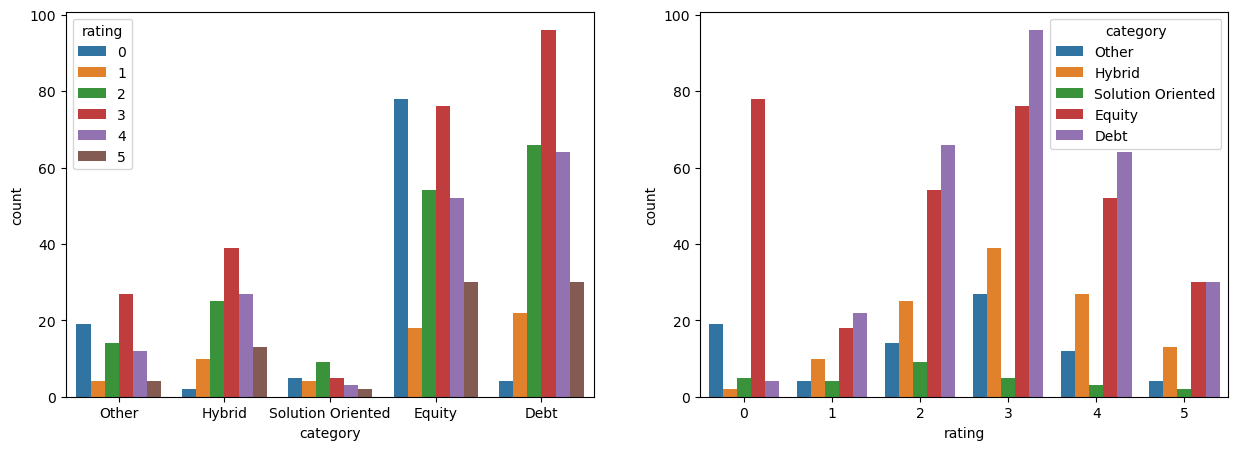

In [35]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax=ax.ravel()
sns.countplot("category",hue="rating",data=mf_data,ax=ax[0])
sns.countplot("rating",hue="category",data=mf_data,ax=ax[1])
plt.show()

1. Ratings in Equity fund is always less than Debt fund.

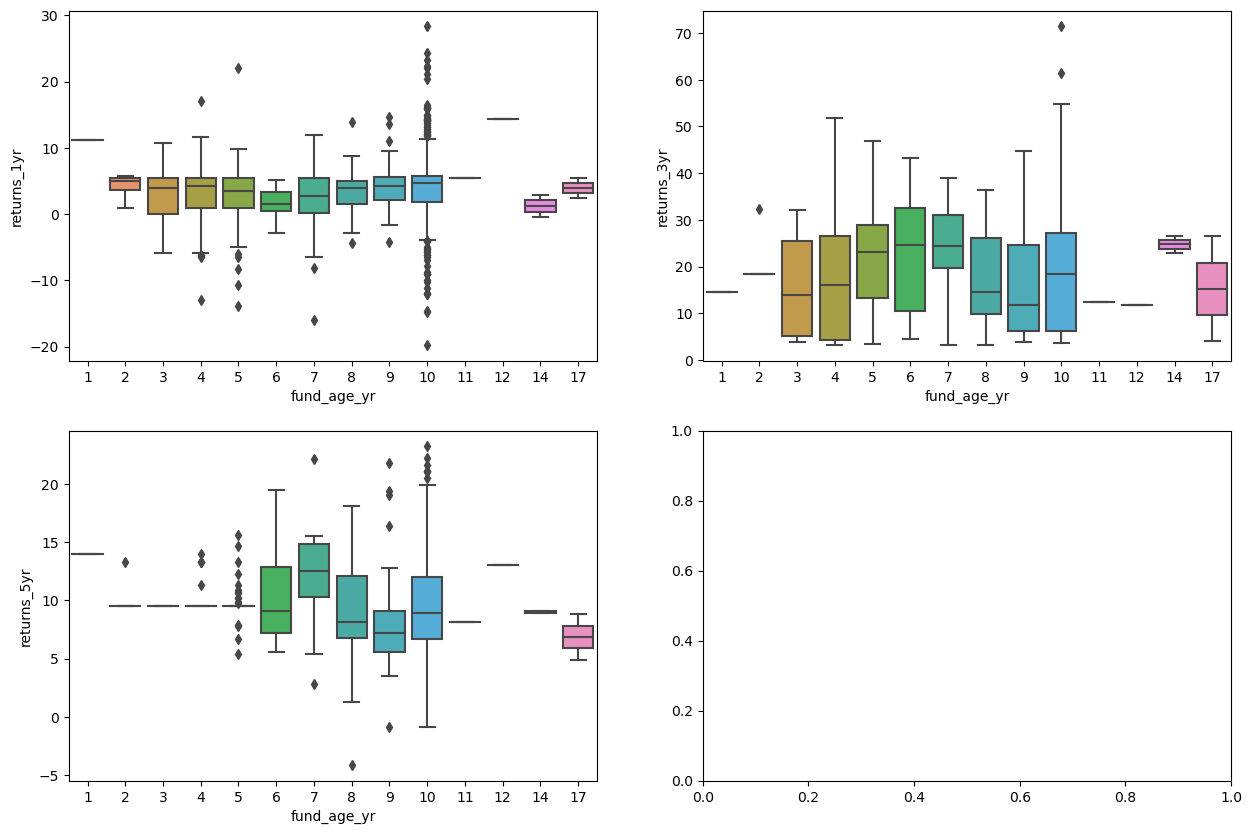

In [36]:
returns=["returns_1yr","returns_3yr","returns_5yr"]
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.ravel()
i=0
for col in returns:
    sns.boxplot(y=col,x="fund_age_yr",data=mf_data,ax=ax[i])
    i+=1
plt.show()

1. Fund's age does not play any major role for return in 1 year.
2. if fund's age is 5 to 7 then there is a minor chance to get good return in 3 years.
3. for 5 years there is a good return if fund's age is 7.

## Multivariate 

In [37]:
mf_data.head()

scheme_name  min_sip  min_lumpsum  \
0  Aditya Birla SL Active Debt Multi-Mgr FoF-Dir ...      100          100   
1                     Aditya Birla SL Arbitrage Fund     1000         1000   
2     Aditya Birla SL Asset Allocator FoF-Dir Growth     1000         1000   
3   Aditya Birla SL Bal Bhavishya Yojna – Dir Growth      500         1000   
4            Aditya Birla SL Balanced Advantage Fund      100          100   

   expense_ratio  fund_size_cr  fund_age_yr        fund_manager  sortino  \
0           0.27          10.0           10      Kaustubh Gupta     0.32   
1           0.36        4288.0           10    Lovelish Solanki     1.33   
2           0.53         157.0           10  Vinod Narayan Bhat     3.44   
3           0.76         637.0            4         Atul Penkar     2.18   
4           0.61        6386.0           10        Mohit Sharma     3.69   

   alpha     sd  beta  sharpe  risk_level                           amc_name  \
0   2.24   9.39  0.01    0.24           3  Aditya Birla Sun Life Mutual Fund   
1   1.53   0.72  0.56    1.10           1  Aditya Birla Sun Life Mutual Fund   
2   2.67  10.58  0.67    1.42           5  Aditya Birla Sun Life Mutual Fund   
3  -6.37  14.99  0.85    0.90           6  Aditya Birla Sun Life Mutual Fund   
4   1.99  10.38  0.68    1.39           6  Aditya Birla Sun Life Mutual Fund   

   rating           category                                    sub_category  \
0       3              Other                                   FoFs Domestic   
1       3             Hybrid                          Arbitrage Mutual Funds   
2       3              Other                                   FoFs Domestic   
3       2  Solution Oriented                                 Childrens Funds   
4       4             Hybrid  Dynamic Asset Allocation or Balanced Advantage   

   returns_1yr  returns_3yr  returns_5yr  
0          4.0          6.5     6.900000  
1          5.6          4.8     5.500000  
2          2.0         18.9     9.700000  
3         -0.7         17.1     9.490726  
4          4.5         18.6     9.700000

## 1. Show top 5 sub-category based on avg return in each year when minimum lumpsum is 1000 and fund's age is more than 4

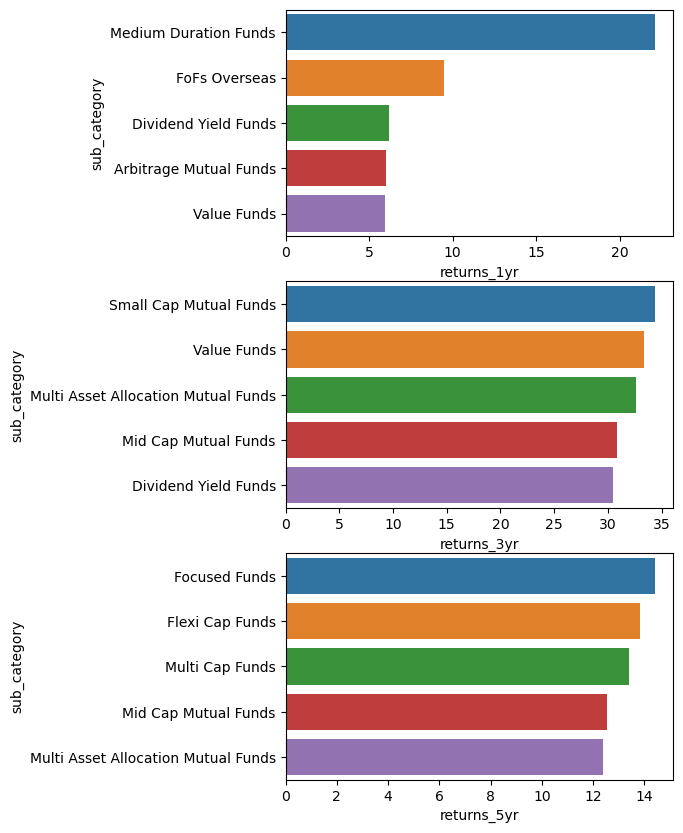

In [38]:
returns=["returns_1yr","returns_3yr","returns_5yr"]
fig,ax=plt.subplots(3,1,figsize=(5,10))
ax=ax.ravel()
i=0
for col in returns:
    cond1=(mf_data["min_lumpsum"]==1000)&(mf_data["fund_age_yr"]>4)
    data1=mf_data[cond1]
    data1=pd.pivot_table(data1,values=col,index="sub_category",aggfunc="mean")
    data1=data1.sort_values(col,ascending=False).head(5)
    sns.barplot(y=data1.index,x=col,data=data1,ax=ax[i])
    
    i+=1
plt.show()

## 2. Show top 5 amc_name based on avg return in each year when fund size is more than 1000 and rating is more than 3

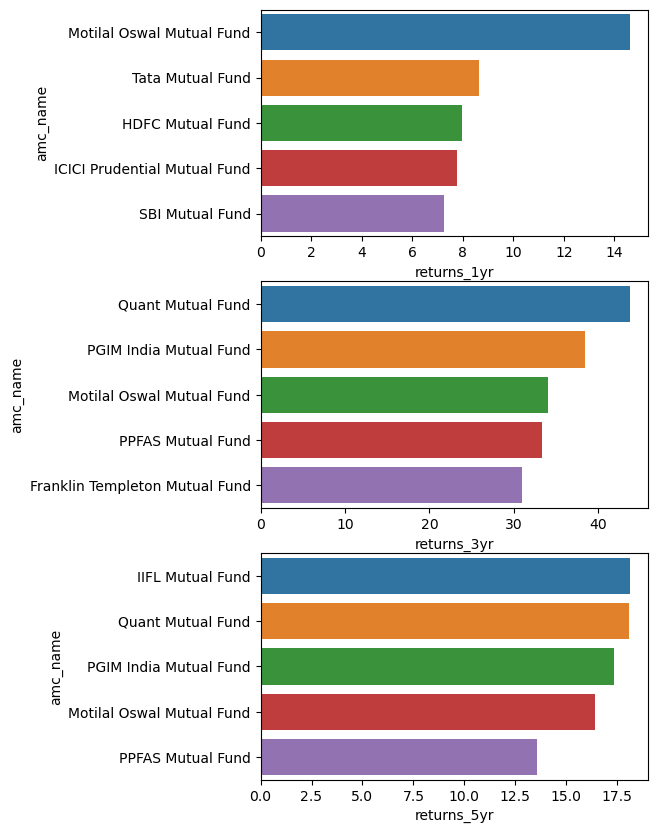

In [39]:
returns=["returns_1yr","returns_3yr","returns_5yr"]
fig,ax=plt.subplots(3,1,figsize=(5,10))
ax=ax.ravel()
i=0
for col in returns:
    cond1=(mf_data["fund_size_cr"]>1000)&(mf_data["rating"]>3)
    data1=mf_data[cond1]
    data1=pd.pivot_table(data1,values=col,index="amc_name",aggfunc="mean")
    data1=data1.sort_values(col,ascending=False).head(5)
    sns.barplot(y=data1.index,x=col,data=data1,ax=ax[i],orient="h")
    
    i+=1
plt.show()

## 3. Show Minimum Lumpsum with avg return in each year when category is Equity ,Fund rating and risk level are more than 3.

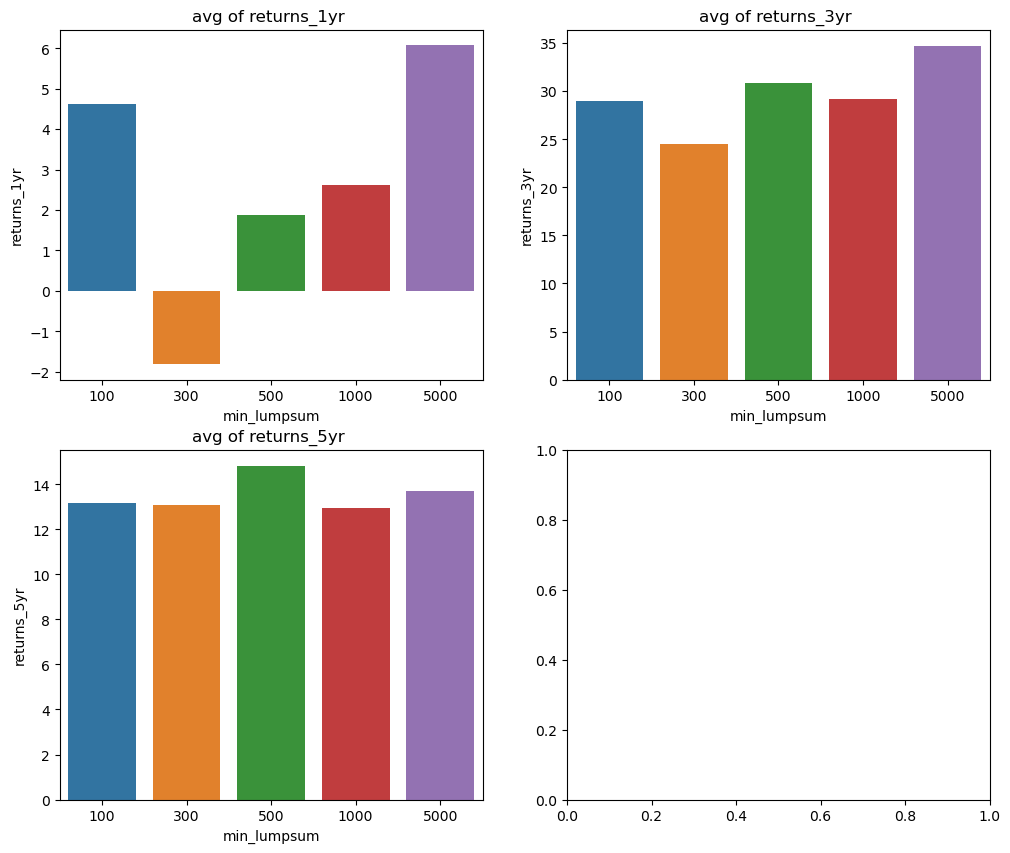

In [40]:
returns=["returns_1yr","returns_3yr","returns_5yr"]
fig,ax=plt.subplots(2,2,figsize=(12,10))
ax=ax.ravel()
i=0
for col in returns:
    cond1=(mf_data["category"]=="Equity")&(mf_data["rating"]>3)&(mf_data["risk_level"]>3)
    data1=mf_data[cond1]
    data1=pd.pivot_table(data1,values=col,index="min_lumpsum",aggfunc="mean")
    data1=data1.sort_values(col,ascending=False)
    sns.barplot(x=data1.index,y=col,data=data1,ax=ax[i])
    ax[i].set_title(f"avg of {col} ")
    
    i+=1
plt.show()

## 4. Show Minimum sip with avg return in each year when category is Equity ,Fund rating and risk level are more than 3.

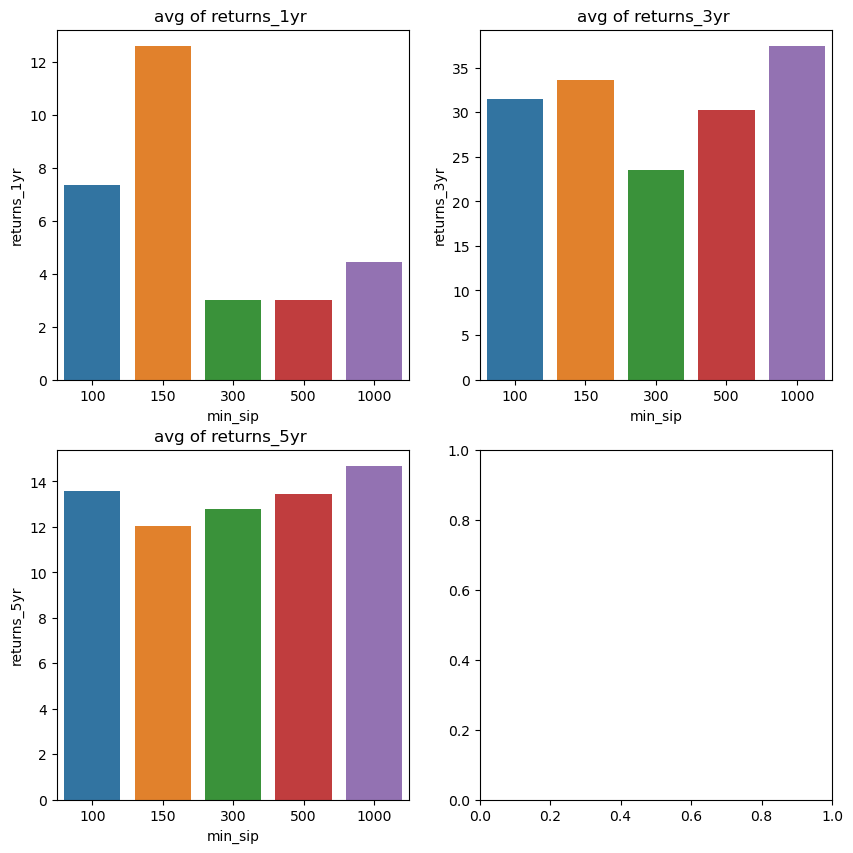

In [41]:
returns=["returns_1yr","returns_3yr","returns_5yr"]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax=ax.ravel()
i=0
for col in returns:
    cond1=(mf_data["category"]=="Equity")&(mf_data["rating"]>3)&(mf_data["risk_level"]>3)
    data1=mf_data[cond1]
    data1=pd.pivot_table(data1,values=col,index="min_sip",aggfunc="mean")
    data1=data1.sort_values(col,ascending=False)
    sns.barplot(x=data1.index,y=col,data=data1,ax=ax[i])
    ax[i].set_title(f"avg of {col} ")
    
    i+=1
plt.show()

## 5. Show ranges and distribution of returns in diff years when rating is more than 2 , risk level is more than 3 and sip amount is 1000 or more than that.

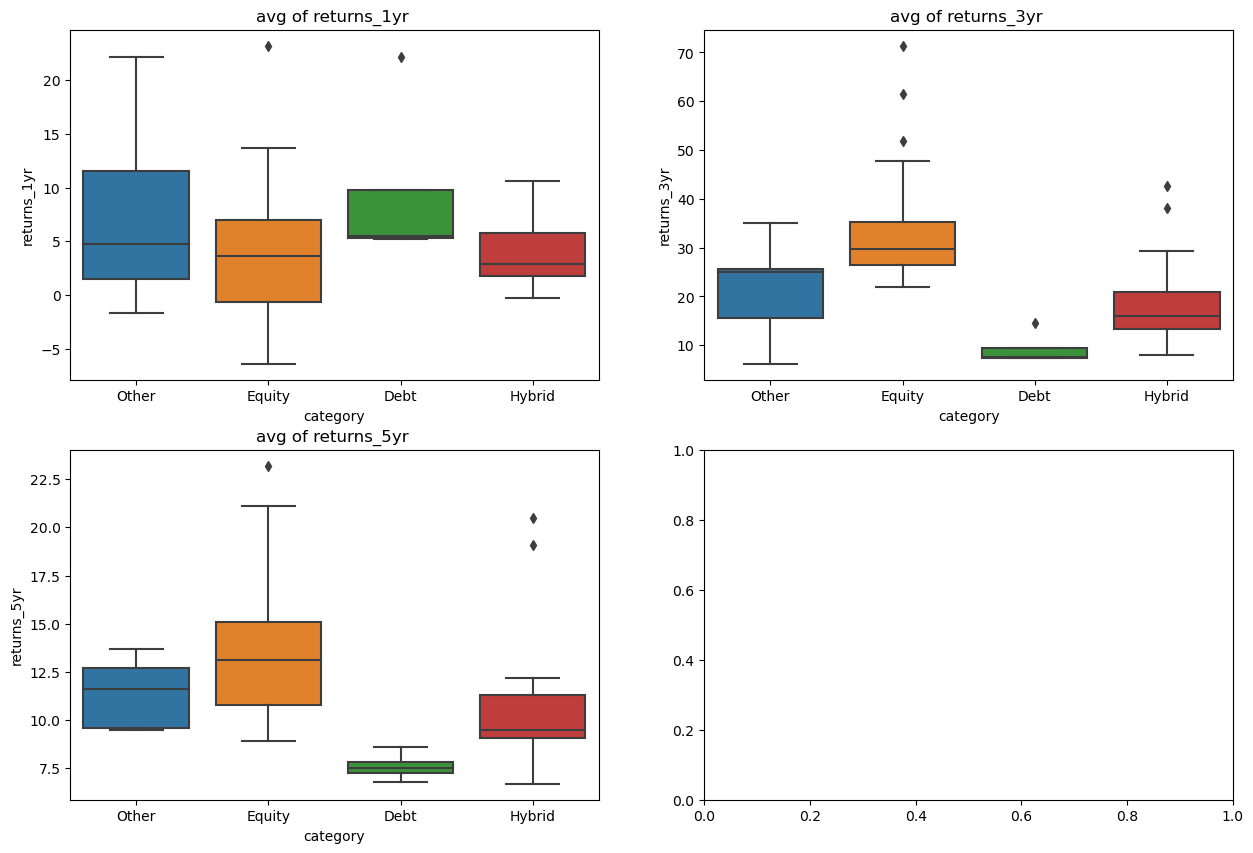

In [42]:
returns=["returns_1yr","returns_3yr","returns_5yr"]
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.ravel()
i=0
for col in returns:
    cond1=(mf_data["rating"]>2)&(mf_data["risk_level"]>3)&(mf_data["min_sip"]>=1000)
    data1=mf_data[cond1]
    sns.boxplot(y=col,x="category",data=data1,ax=ax[i])
    ax[i].set_title(f"avg of {col} ")
    
    i+=1
plt.show()

1. Debt fund gives very bad returns in 3 and 5 years and Equity fund is giving good return in this 3 and 5 years

## 5. Show ranges and distribution of returns in diff years when rating is more than 3 and sip amount is 500 or more than that.

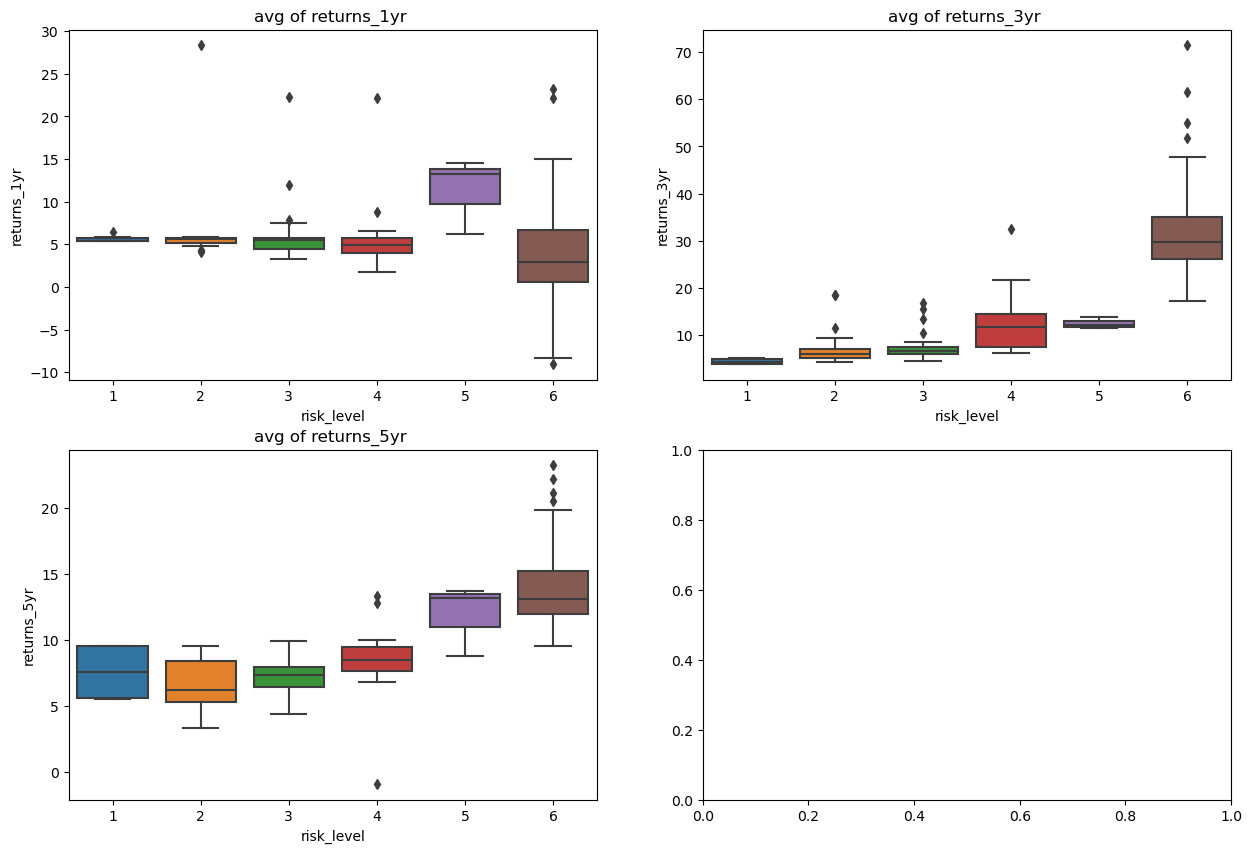

In [43]:
returns=["returns_1yr","returns_3yr","returns_5yr"]
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.ravel()
i=0
for col in returns:
    cond1=(mf_data["rating"]>3)&(mf_data["min_sip"]>=500)
    data1=mf_data[cond1]
    sns.boxplot(y=col,x="risk_level",data=data1,ax=ax[i])
    ax[i].set_title(f"avg of {col} ")
    
    i+=1
plt.show()

1. for year 3 and 5, more the risk level , return will high.

## Expotation to CSV file

In [44]:
#mf_data.to_csv("mf_data_20-06-23.csv")

## Expotation to MySQL Database

In [45]:
# host="localhost"
# user="root"
# password="1%40panchu"
# db="mutual_funds"

In [46]:
#engine=create_engine("mysql://{user}:{pw}@{host}/{db}".format(host=host,db=db,pw=password,user=user))

In [47]:
#mf_data.to_sql("mf_table",engine,index=False)

## --------------------------------------------------Machine learning Models-----------------------------------------------

In [48]:
mf_data.head()

scheme_name  min_sip  min_lumpsum  \
0  Aditya Birla SL Active Debt Multi-Mgr FoF-Dir ...      100          100   
1                     Aditya Birla SL Arbitrage Fund     1000         1000   
2     Aditya Birla SL Asset Allocator FoF-Dir Growth     1000         1000   
3   Aditya Birla SL Bal Bhavishya Yojna – Dir Growth      500         1000   
4            Aditya Birla SL Balanced Advantage Fund      100          100   

   expense_ratio  fund_size_cr  fund_age_yr        fund_manager  sortino  \
0           0.27          10.0           10      Kaustubh Gupta     0.32   
1           0.36        4288.0           10    Lovelish Solanki     1.33   
2           0.53         157.0           10  Vinod Narayan Bhat     3.44   
3           0.76         637.0            4         Atul Penkar     2.18   
4           0.61        6386.0           10        Mohit Sharma     3.69   

   alpha     sd  beta  sharpe  risk_level                           amc_name  \
0   2.24   9.39  0.01    0.24           3  Aditya Birla Sun Life Mutual Fund   
1   1.53   0.72  0.56    1.10           1  Aditya Birla Sun Life Mutual Fund   
2   2.67  10.58  0.67    1.42           5  Aditya Birla Sun Life Mutual Fund   
3  -6.37  14.99  0.85    0.90           6  Aditya Birla Sun Life Mutual Fund   
4   1.99  10.38  0.68    1.39           6  Aditya Birla Sun Life Mutual Fund   

   rating           category                                    sub_category  \
0       3              Other                                   FoFs Domestic   
1       3             Hybrid                          Arbitrage Mutual Funds   
2       3              Other                                   FoFs Domestic   
3       2  Solution Oriented                                 Childrens Funds   
4       4             Hybrid  Dynamic Asset Allocation or Balanced Advantage   

   returns_1yr  returns_3yr  returns_5yr  
0          4.0          6.5     6.900000  
1          5.6          4.8     5.500000  
2          2.0         18.9     9.700000  
3         -0.7         17.1     9.490726  
4          4.5         18.6     9.700000

In [49]:
mf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   scheme_name    814 non-null    object 
 1   min_sip        814 non-null    int64  
 2   min_lumpsum    814 non-null    int64  
 3   expense_ratio  814 non-null    float64
 4   fund_size_cr   814 non-null    float64
 5   fund_age_yr    814 non-null    int64  
 6   fund_manager   814 non-null    object 
 7   sortino        814 non-null    float64
 8   alpha          814 non-null    float64
 9   sd             814 non-null    float64
 10  beta           814 non-null    float64
 11  sharpe         814 non-null    float64
 12  risk_level     814 non-null    int64  
 13  amc_name       814 non-null    object 
 14  rating         814 non-null    int64  
 15  category       814 non-null    object 
 16  sub_category   814 non-null    object 
 17  returns_1yr    814 non-null    float64
 18  returns_3y

In [50]:
for col in mf_data.select_dtypes("object"):
    mf_data[col]=LabelEncoder().fit_transform(mf_data[col])

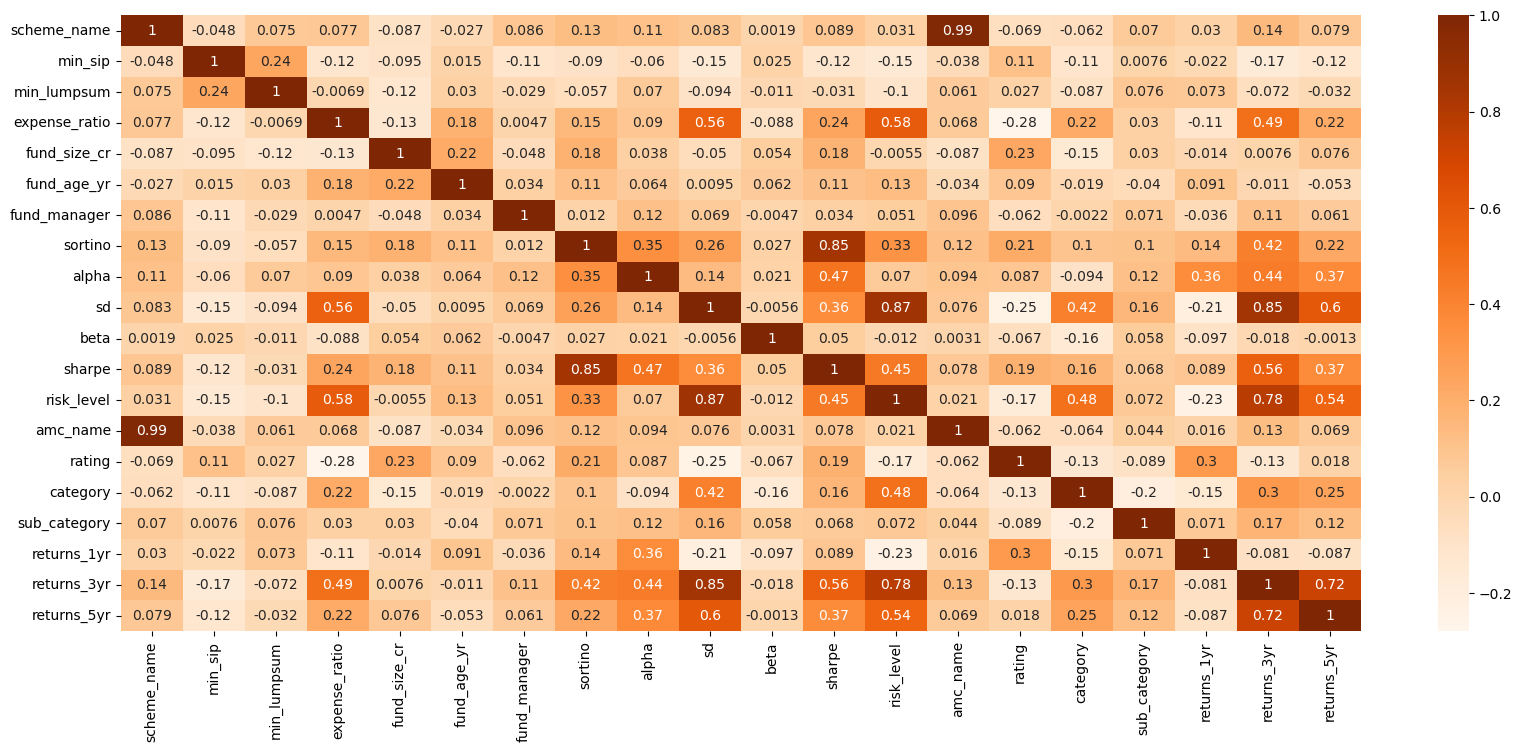

In [51]:
plt.figure(figsize=(20,8))
sns.heatmap(mf_data.corr(),annot=True,cmap="Oranges")
plt.show()

In [52]:
mf_data=mf_data.drop(["sortino","amc_name","risk_level"],axis=1)

## ------------------------------------------------------ ML Models--------------------------------------------------------------

### Collection of metrics

In [53]:
def adjusted_r2_score(model,x,y):
    r2_scores=model.score(x,y)
    n=x.count()
    x=len(x_test.columns)-1
    adjusted_r2_score=1-((1-r2_scores)*(n-1)/(n-x-1))
    return adjusted_r2_score[0]

In [54]:
r2_train=[]
r2_test=[]
rmse=[]
mse=[]
mae=[]
mape=[]
def metrics():
    r2_train.append(R2_TRAIN)
    r2_test.append(R2_TEST)
    rmse.append(RMSE)
    mse.append(MSE)
    mae.append(MAE)
    mape.append(MAPE)

In [55]:
def metrics_print(model):
    print("Model adjusted r2 score on training data :",adjusted_r2_score(model,x_train,y_train))
    print("Model adjusted r2 score on test data :",adjusted_r2_score(model,x_test,y_test))
    
    average_adjusted_r2_score_train.append(adjusted_r2_score(model,x_train,y_train))
    average_adjusted_r2_score_test.append(adjusted_r2_score(model,x_test,y_test))
    print()
    
    RMSE1=mean_squared_error(y_test,y_pred,squared=False)
    print("RMSE:",RMSE1)
    avg_rmse.append(RMSE1)
    
    MSE1=mean_squared_error(y_test,y_pred)
    print("MSE:",MSE1)
    avg_mse.append(MSE1)
    
    MAE1=mean_absolute_error(y_test,y_pred)
    print("MAE:",MAE1)
    avg_mae.append(MAE1)
    
    MAPE1=mean_absolute_percentage_error(y_test,y_pred)
    print("MAPE:",MAPE1)
    avg_mape.append(MAPE1)
    print("--"*50)


In [56]:
def metrics_print1(model):
    R2_TRAIN=adjusted_r2_score(model,x_train,y_train)
    R2_TEST=adjusted_r2_score(model,x_test,y_test)
    print("Model adjusted r2 score on training data :",R2_TRAIN)
    print("Model adjusted r2 score on test data:",R2_TEST)
    print()


    RMSE=mean_squared_error(y_test,y_pred,squared=False)
    print("RMSE:",RMSE)

    MSE=mean_squared_error(y_test,y_pred)
    print("MSE:",MSE)

    MAE=mean_absolute_error(y_test,y_pred)
    print("MAE:",MAE)

    MAPE=mean_absolute_percentage_error(y_test,y_pred)
    print("MAPE:",MAPE)

    r2_train.append(R2_TRAIN)
    r2_test.append(R2_TEST)
    rmse.append(RMSE)
    mse.append(MSE)
    mae.append(MAE)
    mape.append(MAPE)

## ---------------------------------------------- Prediction for 1 year---------------------------------------------------------

In [57]:
A=mf_data.drop(["returns_1yr","returns_3yr","returns_5yr"],axis=1)
y1=mf_data["returns_1yr"]

scaled_data=pd.DataFrame(StandardScaler().fit_transform(A),columns=A.columns)
scaled_data["returns_1yr"]=y1
X=scaled_data.drop("returns_1yr",axis=1)

## Split

In [58]:
x_train,x_test,y_train,y_test=train_test_split(X,y1,test_size=0.3,random_state=42)

In [59]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)

## -----------------------------------------------Multi-linear Regression-----------------------------------------------------

In [60]:
average_adjusted_r2_score_train=[]
average_adjusted_r2_score_test=[]
avg_rmse=[]
avg_mse=[]
avg_mae=[]
avg_mape=[]
for train_data,test_data in kf.split(scaled_data):
    train,test=scaled_data.iloc[train_data],scaled_data.iloc[test_data]
    x_train=train.drop(["returns_1yr"],axis=1)
    y_train=train["returns_1yr"]
    
    x_test=test.drop(["returns_1yr"],axis=1)
    y_test=test["returns_1yr"]
    
    lin_model=LinearRegression().fit(x_train,y_train)
    y_pred=lin_model.predict(x_test)
    
    print("Intercept:",lin_model.intercept_)
    print("slope:",lin_model.coef_)
    print()
    
    metrics_print(lin_model)
    
RMSE=np.mean(avg_rmse)  
MSE=np.mean(avg_mse) 
MAE=np.mean(avg_mae) 
MAPE=np.mean(avg_mape)
R2_TRAIN=np.mean(average_adjusted_r2_score_train)
R2_TEST=np.mean(average_adjusted_r2_score_test)

print("Average adjusted r2 score of train data on different K-Fold",R2_TRAIN)
print("Average adjusted r2 score of test data on different K-Fold",R2_TEST)
metrics()

Intercept: 3.814618284028129
slope: [ 0.11522994 -0.41578883 -0.01213729 -0.04361181 -0.5163618   0.40401075
 -0.27609198  2.01547224 -0.98951318 -0.38279421 -0.31734701  1.19214795
  0.03681105  0.4984646 ]

Model adjusted r2 score on training data : 0.27052854309596985
Model adjusted r2 score on test data : 0.2216655252318579

RMSE: 4.644932269555498
MSE: 21.57539578875799
MAE: 2.860362883383458
MAPE: 1.3934951746869781
----------------------------------------------------------------------------------------------------
Intercept: 3.6791059580993415
slope: [ 0.00752419 -0.44422735 -0.08404886  0.2115801  -0.45160143  0.45440668
 -0.37302713  1.97170873 -1.26962849 -0.46444782 -0.34156001  1.20891672
 -0.05120226  0.52781766]

Model adjusted r2 score on training data : 0.28618360394558306
Model adjusted r2 score on test data : 0.1453718333937939

RMSE: 4.347780451589987
MSE: 18.90319485522803
MAE: 2.918524309439992
MAPE: 174059158486762.72
----------------------------------------------

## Decision Tree Regression

In [61]:
x_train,x_test,y_train,y_test=train_test_split(X,y1,test_size=0.3,random_state=42)

In [324]:
param_grid={'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [325]:
dt=DecisionTreeRegressor()

In [326]:
grid_cv=GridSearchCV(dt,param_grid,scoring="r2",cv=kf)

In [65]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50])},
             scoring='r2')

In [66]:
grid_cv.best_estimator_

DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, min_samples_split=50)

In [62]:
dt_model=DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, min_samples_split=50).fit(x_train,y_train)
y_pred=dt_model.predict(x_test)

In [63]:
metrics_print1(dt_model)

Model adjusted r2 score on training data : 0.5126334459978721
Model adjusted r2 score on test data: 0.4047438238376644

RMSE: 4.070709487990685
MSE: 16.570675735617385
MAE: 2.517605088130774
MAPE: 127755173102960.14


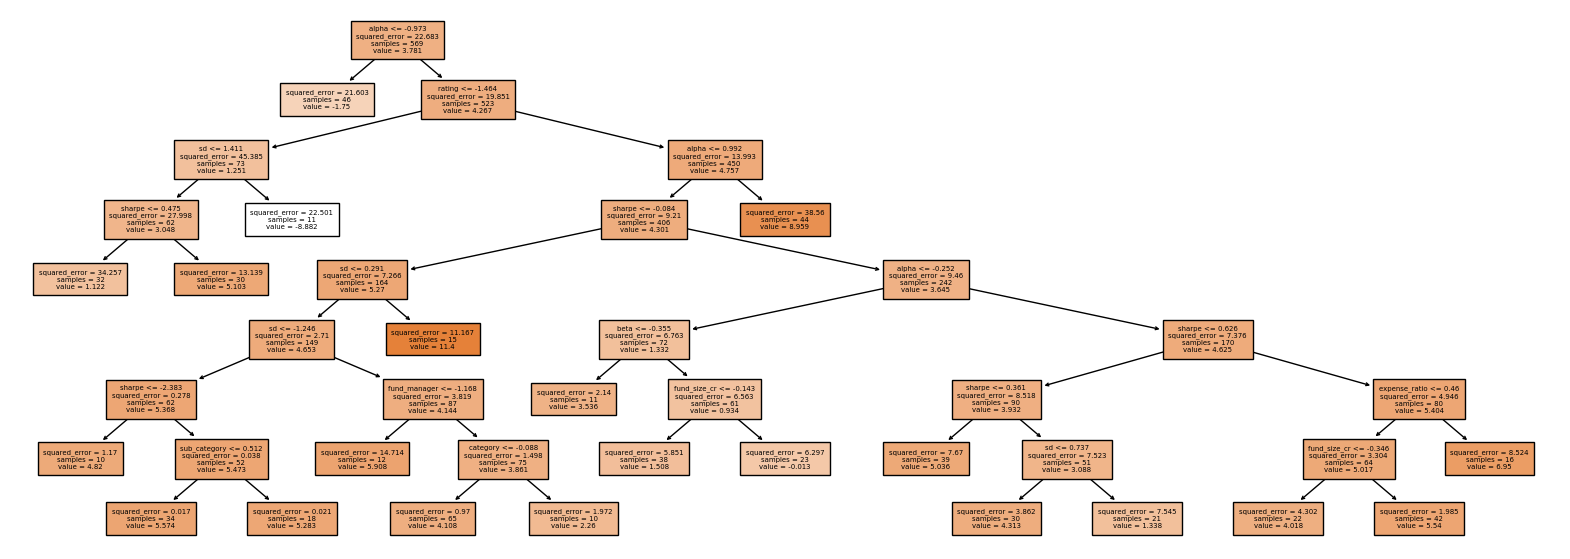

In [329]:
plt.figure(figsize=(20,7))
tree.plot_tree(dt_model,feature_names=X.columns,filled=True,fontsize=5)
plt.show()

## Random Forest Regression

In [330]:
param_grid={'n_estimators':np.arange(20,101,20),
           'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [331]:
rf=RandomForestRegressor()

In [332]:
grid_cv=GridSearchCV(rf,param_grid,scoring="r2",cv=kf)

In [73]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50]),
                         'n_estimators': array([ 20,  40,  60,  80, 100])},
             scoring='r2')

In [74]:
grid_cv.best_estimator_

RandomForestRegressor(max_depth=11, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=60)

In [64]:
rf_model=RandomForestRegressor(max_depth=11, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=60,random_state=42).fit(x_train,y_train)
y_pred=rf_model.predict(x_test)

In [65]:
metrics_print1(rf_model)

Model adjusted r2 score on training data : 0.5772867485747692
Model adjusted r2 score on test data: 0.38145506672915386

RMSE: 4.149576554987698
MSE: 17.218985585703575
MAE: 2.395867671894762
MAPE: 86940013725943.75


## Adaboost Regression

In [335]:
param_grid={"n_estimators": np.arange(10,101,10),
           "learning_rate":np.arange(0.05,1,0.05)}

In [336]:
ada=AdaBoostRegressor()

In [337]:
grid_cv=GridSearchCV(ada,param_grid,scoring="r2",cv=kf)

In [80]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='r2')

In [81]:
grid_cv.best_estimator_

AdaBoostRegressor(learning_rate=0.4, n_estimators=60)

In [66]:
ada_model=AdaBoostRegressor(learning_rate=0.4, n_estimators=60, random_state=42).fit(x_train,y_train)
y_pred=ada_model.predict(x_test)

In [67]:
metrics_print1(ada_model)

Model adjusted r2 score on training data : 0.5203706182939142
Model adjusted r2 score on test data: 0.33248655152648243

RMSE: 4.310703620921749
MSE: 18.58216570742788
MAE: 2.8626019308811808
MAPE: 100687489314293.55


## K-Nearest Neighbour

In [340]:
r2_scores=[]
for k in range(2,25):
    knn_score=cross_val_score(KNeighborsRegressor(k),x_train,y_train,scoring="r2",cv=kf)
    r2_scores.append(np.mean(knn_score))

In [341]:
for k in range(2,25):
    print("number of neighbors:",k,":",r2_scores[k-2])

number of neighbors: 2 : -0.028021845405804546
number of neighbors: 3 : 0.11520944931507016
number of neighbors: 4 : 0.1549049918148238
number of neighbors: 5 : 0.19953515060305282
number of neighbors: 6 : 0.23516491226833117
number of neighbors: 7 : 0.23901285605088668
number of neighbors: 8 : 0.2239799363250568
number of neighbors: 9 : 0.2285422089840737
number of neighbors: 10 : 0.2220392440172158
number of neighbors: 11 : 0.216443781588392
number of neighbors: 12 : 0.2115162107272961
number of neighbors: 13 : 0.19790352431126496
number of neighbors: 14 : 0.20002861647391046
number of neighbors: 15 : 0.2086191157848873
number of neighbors: 16 : 0.20869640471293663
number of neighbors: 17 : 0.211540327232102
number of neighbors: 18 : 0.2055348423981044
number of neighbors: 19 : 0.2015683525873441
number of neighbors: 20 : 0.19226281857826302
number of neighbors: 21 : 0.19079322665174508
number of neighbors: 22 : 0.18538255890375138
number of neighbors: 23 : 0.17926108469315283
number

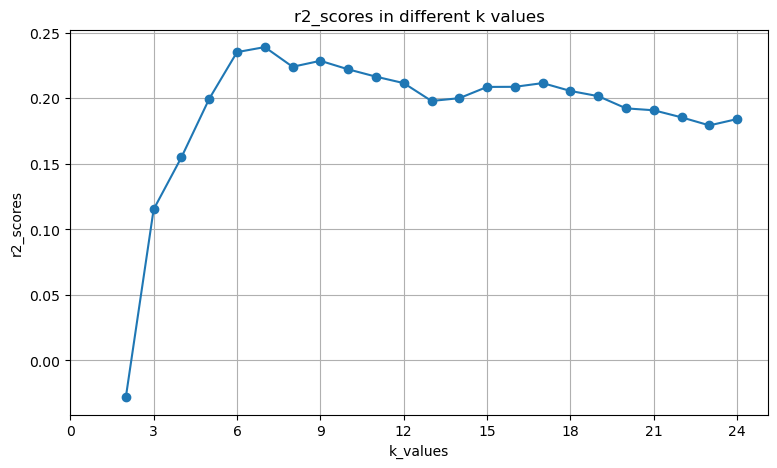

In [342]:
plt.figure(figsize=(9,5))
plt.plot(range(2,25),r2_scores,marker="o")
plt.ylabel("r2_scores")
plt.xlabel("k_values")
plt.title("r2_scores in different k values")
plt.xticks(range(0,25,3))
plt.grid()
plt.show()

In [68]:
k=7
knn_model=KNeighborsRegressor(k).fit(x_train,y_train)
y_pred=knn_model.predict(x_test)

In [69]:
metrics_print1(knn_model)

Model adjusted r2 score on training data : 0.4396366612968412
Model adjusted r2 score on test data: 0.2105390984326595

RMSE: 4.687955358973688
MSE: 21.976925447730114
MAE: 2.8048396501457726
MAPE: 59085126306611.31


## Stacked Regression

In [70]:
level1=[]
level1.append(("lr",LinearRegression()))
level1.append(("dt",DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, min_samples_split=50)))
level1.append(("rf",RandomForestRegressor(max_depth=11, min_samples_leaf=10, min_samples_split=10,n_estimators=60,random_state=42)))
level1.append(("ada",AdaBoostRegressor(learning_rate=0.4, n_estimators=60, random_state=42)))
level1.append(("knn",KNeighborsRegressor(7)))
level1.append(("svr",SVR()))

level2=LinearRegression()

In [71]:
stack_model=StackingRegressor(estimators=level1,final_estimator=level2,cv=kf).fit(X,y1)
y_pred=stack_model.predict(x_test)

In [72]:
metrics_print1(stack_model)

Model adjusted r2 score on training data : 0.6128097571915789
Model adjusted r2 score on test data: 0.677408428425128

RMSE: 2.996709623265503
MSE: 8.980268566172072
MAE: 1.949720712278658
MAPE: 80165548523299.19


## ----------------------------------------- Best Model Selection for 1st year--------------------------------------------

In [73]:
model_list=["Linear Regression","Decision Tree Regression","Random Forest Regression","Ada-boost Regression","KNN Regression","Stacked Regression"]
metric_list=["Models","r2 Score(Train)","r2 Score(Test)","RMSE","MSE","MAE","MAPE"]

In [74]:
final_results=pd.DataFrame()
for i in range(0,len(model_list)):
    x=[[model_list[i],r2_train[i],r2_test[i],rmse[i],mse[i],mae[i],mape[i]]]
    new=pd.DataFrame(x)
    final_results=pd.concat([final_results,new],axis=0)
final_results.columns=metric_list
final_results=final_results.reset_index(drop=True)  
final_results

Models  r2 Score(Train)  r2 Score(Test)      RMSE  \
0         Linear Regression         0.275307        0.190557  4.267463   
1  Decision Tree Regression         0.512633        0.404744  4.070709   
2  Random Forest Regression         0.577287        0.381455  4.149577   
3      Ada-boost Regression         0.520371        0.332487  4.310704   
4            KNN Regression         0.439637        0.210539  4.687955   
5        Stacked Regression         0.612810        0.677408  2.996710   

         MSE       MAE          MAPE  
0  18.257611  2.802838  3.724865e+13  
1  16.570676  2.517605  1.277552e+14  
2  17.218986  2.395868  8.694001e+13  
3  18.582166  2.862602  1.006875e+14  
4  21.976925  2.804840  5.908513e+13  
5   8.980269  1.949721  8.016555e+13

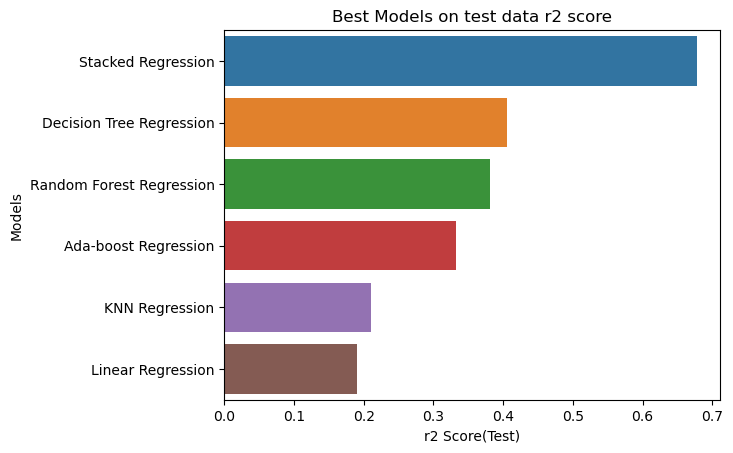

In [75]:
results=final_results.sort_values("r2 Score(Test)",ascending=False)
sns.barplot(x="r2 Score(Test)",y="Models",data=results)
plt.title("Best Models on test data r2 score")
plt.show()

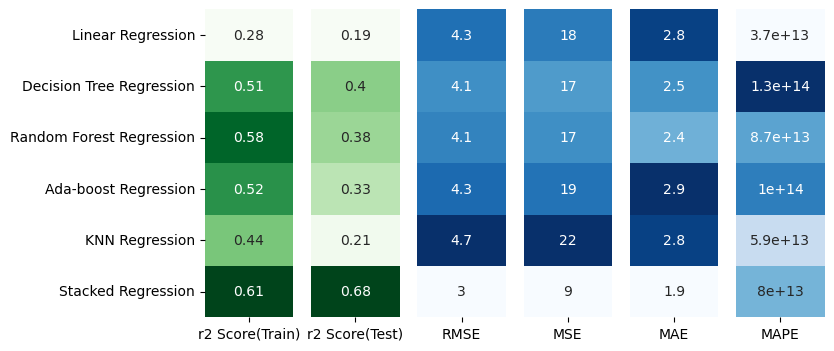

In [85]:
fig,ax=plt.subplots(1,6,figsize=(8,4))

sns.heatmap(final_results[["r2 Score(Train)"]],annot=True,yticklabels=model_list,ax=ax[0],cbar=False,cmap="Greens")
sns.heatmap(final_results[["r2 Score(Test)"]],annot=True,ax=ax[1],yticklabels=False,cbar=False,cmap="Greens")
sns.heatmap(final_results[["RMSE"]],annot=True,ax=ax[2],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MSE"]],annot=True,ax=ax[3],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MAE"]],annot=True,ax=ax[4],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MAPE"]],annot=True,ax=ax[5],yticklabels=False,cbar=False,cmap="Blues")

plt.show()

In [87]:
lin_score=average_adjusted_r2_score_test
dt_score=cross_val_score(dt_model,X,y1,scoring="r2",cv=kf)
rf_score=cross_val_score(rf_model,X,y1,scoring="r2",cv=kf)
ada_score=cross_val_score(ada_model,X,y1,scoring="r2",cv=kf)
knn_score=cross_val_score(knn_model,X,y1,scoring="r2",cv=kf)
stack_score=cross_val_score(stack_model,X,y1,scoring="r2",cv=kf)

all_scores=[lin_score,dt_score,rf_score,ada_score,knn_score,stack_score]

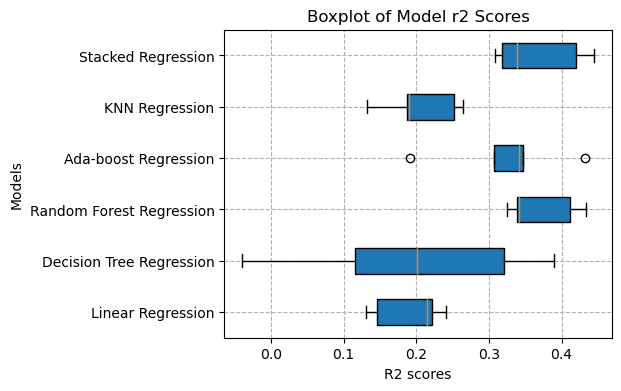

In [88]:
plt.figure(figsize=(5,4))
plt.boxplot(all_scores,labels=model_list,vert=False,patch_artist=True)
plt.title("Boxplot of Model r2 Scores")
plt.xlabel("R2 scores")
plt.ylabel("Models")
plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', linestyle='--')
plt.show()

## ---------------------------------------------------Prediction for 3 years--------------------------------------------------

In [90]:
A=mf_data.drop(["returns_3yr","returns_5yr"],axis=1)
y3=mf_data["returns_3yr"]

scaled_data=pd.DataFrame(StandardScaler().fit_transform(A),columns=A.columns)
scaled_data["returns_3yr"]=y3
X=scaled_data.drop("returns_3yr",axis=1)

In [91]:
r2_train=[]
r2_test=[]
rmse=[]
mse=[]
mae=[]
mape=[]

## Multi-Linear Regression

In [92]:
average_adjusted_r2_score_train=[]
average_adjusted_r2_score_test=[]
avg_rmse=[]
avg_mse=[]
avg_mae=[]
avg_mape=[]
for train_data,test_data in kf.split(scaled_data):
    train,test=scaled_data.iloc[train_data],scaled_data.iloc[test_data]
    x_train=train.drop(["returns_3yr"],axis=1)
    y_train=train["returns_3yr"]
    
    x_test=test.drop(["returns_3yr"],axis=1)
    y_test=test["returns_3yr"]
    
    lin_model=LinearRegression().fit(x_train,y_train)
    y_pred=lin_model.predict(x_test)
    
    print("Intercept:",lin_model.intercept_)
    print("slope:",lin_model.coef_)
    print()
    
    metrics_print(lin_model)
    
RMSE=np.mean(avg_rmse)  
MSE=np.mean(avg_mse) 
MAE=np.mean(avg_mae) 
MAPE=np.mean(avg_mape)
R2_TRAIN=np.mean(average_adjusted_r2_score_train)
R2_TEST=np.mean(average_adjusted_r2_score_test)

print("Average adjusted r2 score of train data on different K-Fold",R2_TRAIN)
print("Average adjusted r2 score of test data on different K-Fold",R2_TEST)
metrics()

Intercept: 18.540241266006735
slope: [ 0.3874071  -0.28229066 -0.17250526  0.35103927  0.2368482  -0.80136071
  0.19316328  3.07041324  8.65734377 -0.36182744  2.0832654   0.30888904
 -0.04431201  0.31136758 -0.42880572]

Model adjusted r2 score on training data : 0.8510831801010807
Model adjusted r2 score on test data : 0.8389086058797953

RMSE: 4.529101074399542
MSE: 20.512756542127086
MAE: 2.559162135112119
MAPE: 0.23531539526604947
----------------------------------------------------------------------------------------------------
Intercept: 18.560780573654352
slope: [ 3.49510332e-01 -1.28967106e-01 -2.08083776e-03  3.84681015e-01
  2.67904149e-01 -7.45125795e-01  3.16005144e-01  3.19175329e+00
  9.14612570e+00 -2.71392607e-01  1.81097516e+00  4.60350004e-01
 -1.48450324e-01  4.27005649e-02 -4.39648176e-01]

Model adjusted r2 score on training data : 0.8703865646964589
Model adjusted r2 score on test data : 0.735792636890707

RMSE: 5.437177509994704
MSE: 29.562899275192212
MAE: 2.8

## Decision Tree Regression

In [93]:
x_train,x_test,y_train,y_test=train_test_split(X,y3,test_size=0.3,random_state=42)

In [356]:
param_grid={'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [357]:
dt=DecisionTreeRegressor()

In [136]:
grid_cv=GridSearchCV(dt,param_grid,scoring="r2",cv=kf)

In [137]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50])},
             scoring='r2')

In [138]:
grid_cv.best_estimator_

DecisionTreeRegressor(max_depth=6, min_samples_leaf=10, min_samples_split=10)

In [94]:
dt_model=DecisionTreeRegressor(max_depth=6, min_samples_leaf=10, min_samples_split=10).fit(x_train,y_train)
y_pred=dt_model.predict(x_test)

In [95]:
metrics_print1(dt_model)

Model adjusted r2 score on training data : 0.9407933176489428
Model adjusted r2 score on test data: 0.9057071101841941

RMSE: 3.5084701889953886
MSE: 12.309363067069338
MAE: 2.010283322213947
MAPE: 0.11794743706410882


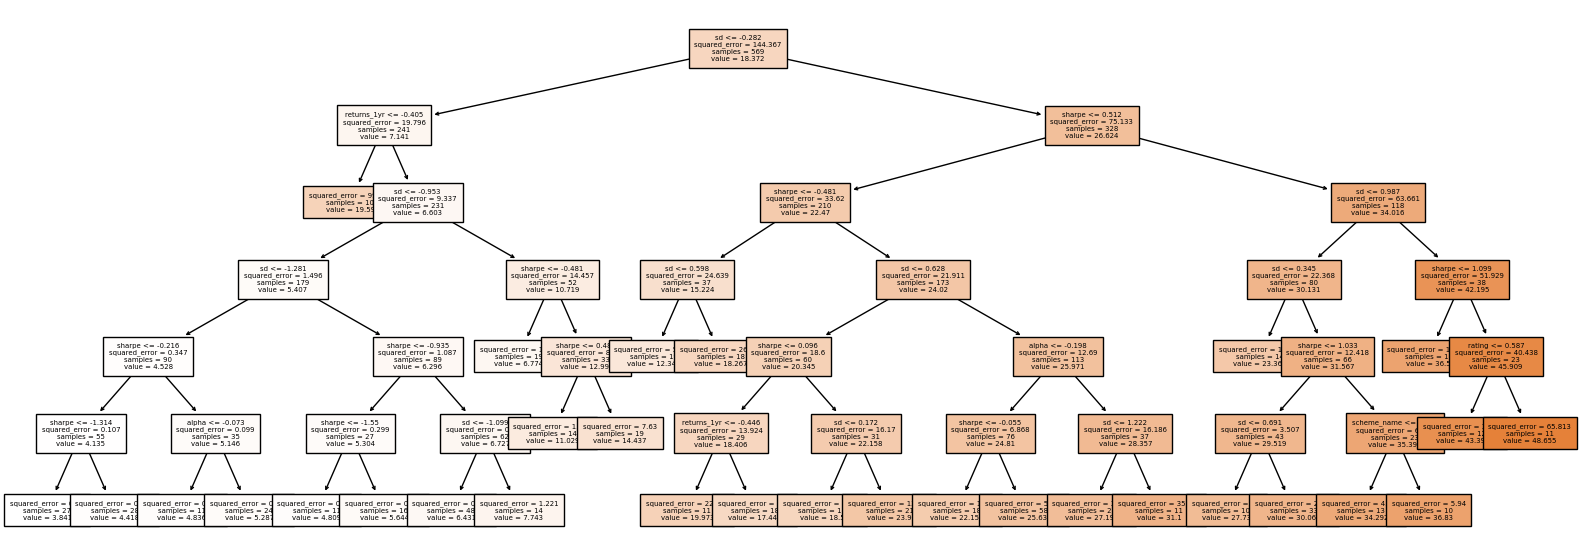

In [360]:
plt.figure(figsize=(20,7))
tree.plot_tree(dt_model,feature_names=X.columns,filled=True,fontsize=5)
plt.show()

## Random Forest Regression

In [361]:
param_grid={'n_estimators':np.arange(20,101,20),
           'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [362]:
rf=RandomForestRegressor()

In [184]:
grid_cv=GridSearchCV(rf,param_grid,scoring="r2",cv=kf)

In [145]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50]),
                         'n_estimators': array([ 20,  40,  60,  80, 100])},
             scoring='r2')

In [146]:
grid_cv.best_estimator_

RandomForestRegressor(max_depth=7, min_samples_leaf=10, min_samples_split=20,
                      n_estimators=60)

In [96]:
rf_model=RandomForestRegressor(max_depth=7, min_samples_leaf=10, min_samples_split=20,
                      n_estimators=60).fit(x_train,y_train)
y_pred=rf_model.predict(x_test)

In [97]:
metrics_print1(rf_model)

Model adjusted r2 score on training data : 0.9370170669521727
Model adjusted r2 score on test data: 0.8895412032822151

RMSE: 3.7973311491415105
MSE: 14.419723856240385
MAE: 1.726146937936207
MAPE: 0.11693008548374946


## Adaboost Regression

In [365]:
param_grid={"n_estimators": np.arange(10,101,10),
           "learning_rate":np.arange(0.05,1,0.05)}

In [366]:
ada=AdaBoostRegressor()

In [189]:
grid_cv=GridSearchCV(ada,param_grid,scoring="r2",cv=kf)

In [152]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='r2')

In [153]:
grid_cv.best_estimator_

AdaBoostRegressor(learning_rate=0.7000000000000001, n_estimators=30)

In [98]:
ada_model=AdaBoostRegressor(learning_rate=0.7, n_estimators=30, random_state=42).fit(x_train,y_train)
y_pred=ada_model.predict(x_test)

In [99]:
metrics_print1(ada_model)

Model adjusted r2 score on training data : 0.932090496560969
Model adjusted r2 score on test data: 0.8812344931658905

RMSE: 3.9375264217654866
MSE: 15.504114322101316
MAE: 2.8577982338603243
MAPE: 0.2759711559569113


## K-Nearest Neighbour

In [369]:
r2_scores=[]
for k in range(2,25):
    knn_score=cross_val_score(KNeighborsRegressor(k),x_train,y_train,scoring="r2",cv=kf)
    r2_scores.append(np.mean(knn_score))

In [370]:
for k in range(2,25):
    print("number of neighbors:",k,":",r2_scores[k-2])

number of neighbors: 2 : 0.7806576475395779
number of neighbors: 3 : 0.8120117318484266
number of neighbors: 4 : 0.824438857613855
number of neighbors: 5 : 0.8324032932431358
number of neighbors: 6 : 0.8301215695724599
number of neighbors: 7 : 0.827500732389564
number of neighbors: 8 : 0.8223560766860187
number of neighbors: 9 : 0.8206963583866518
number of neighbors: 10 : 0.8224600386402668
number of neighbors: 11 : 0.8204873303615239
number of neighbors: 12 : 0.8198174029541493
number of neighbors: 13 : 0.8169199221748643
number of neighbors: 14 : 0.8147636165567503
number of neighbors: 15 : 0.8143431141696645
number of neighbors: 16 : 0.8124763637579427
number of neighbors: 17 : 0.8121280095879909
number of neighbors: 18 : 0.8107889065509312
number of neighbors: 19 : 0.8098705979042332
number of neighbors: 20 : 0.8074243347800042
number of neighbors: 21 : 0.8048036411154167
number of neighbors: 22 : 0.8042164783887784
number of neighbors: 23 : 0.8041963989041807
number of neighbors:

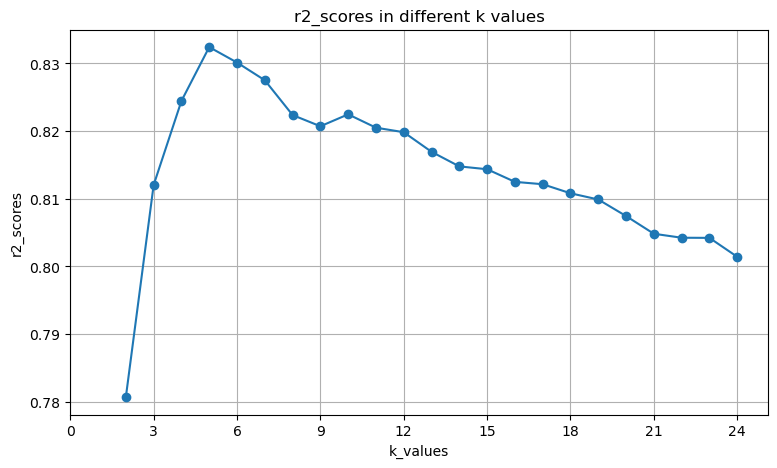

In [371]:
plt.figure(figsize=(9,5))
plt.plot(range(2,25),r2_scores,marker="o")
plt.ylabel("r2_scores")
plt.xlabel("k_values")
plt.title("r2_scores in different k values")
plt.xticks(range(0,25,3))
plt.grid()
plt.show()

In [100]:
k=5
knn_model=KNeighborsRegressor(k).fit(x_train,y_train)
y_pred=knn_model.predict(x_test)

In [101]:
metrics_print1(knn_model)

Model adjusted r2 score on training data : 0.8882749542896746
Model adjusted r2 score on test data: 0.8253363570899406

RMSE: 4.775068155580413
MSE: 22.80127589043812
MAE: 3.0809163857220065
MAPE: 0.21064792561382478


## Stacked Regression

In [102]:
level1=[]
level1.append(("lr",LinearRegression()))
level1.append(("dt",DecisionTreeRegressor(max_depth=6, min_samples_leaf=10, min_samples_split=10)))
level1.append(("rf",RandomForestRegressor(max_depth=7, min_samples_leaf=10, min_samples_split=20,n_estimators=60)))
level1.append(("ada",AdaBoostRegressor(learning_rate=0.7, n_estimators=30, random_state=42)))
level1.append(("knn",KNeighborsRegressor(5)))
level1.append(("svr",SVR()))

level2=LinearRegression()

In [103]:
stack_model=StackingRegressor(estimators=level1,final_estimator=level2,cv=kf).fit(X,y3)
y_pred=stack_model.predict(x_test)

In [104]:
metrics_print1(stack_model)

Model adjusted r2 score on training data : 0.954875627627541
Model adjusted r2 score on test data: 0.9491006100118005

RMSE: 2.5777132656748103
MSE: 6.6446056800358955
MAE: 1.4276142533443439
MAPE: 0.09433825290153908


## ----------------------------------------- Best Model Selection for 3 years--------------------------------------------

In [105]:
model_list=["Linear Regression","Decision Tree Regression","Random Forest Regression","Ada-boost Regression","KNN Regression","Stacked Regression"]
metric_list=["Models","r2 Score(Train)","r2 Score(Test)","RMSE","MSE","MAE","MAPE"]

In [106]:
final_results=pd.DataFrame()
for i in range(0,len(model_list)):
    x=[[model_list[i],r2_train[i],r2_test[i],rmse[i],mse[i],mae[i],mape[i]]]
    new=pd.DataFrame(x)
    final_results=pd.concat([final_results,new],axis=0)
final_results.columns=metric_list
final_results=final_results.reset_index(drop=True)  
final_results

Models  r2 Score(Train)  r2 Score(Test)      RMSE  \
0         Linear Regression         0.851964        0.830746  4.616981   
1  Decision Tree Regression         0.940793        0.905707  3.508470   
2  Random Forest Regression         0.937017        0.889541  3.797331   
3      Ada-boost Regression         0.932090        0.881234  3.937526   
4            KNN Regression         0.888275        0.825336  4.775068   
5        Stacked Regression         0.954876        0.949101  2.577713   

         MSE       MAE      MAPE  
0  21.586543  2.811162  0.232341  
1  12.309363  2.010283  0.117947  
2  14.419724  1.726147  0.116930  
3  15.504114  2.857798  0.275971  
4  22.801276  3.080916  0.210648  
5   6.644606  1.427614  0.094338

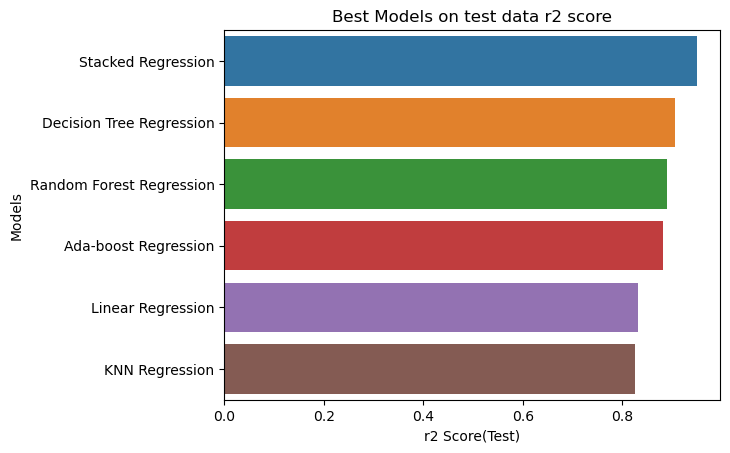

In [107]:
results=final_results.sort_values("r2 Score(Test)",ascending=False)
sns.barplot(x="r2 Score(Test)",y="Models",data=results)
plt.title("Best Models on test data r2 score")
plt.show()

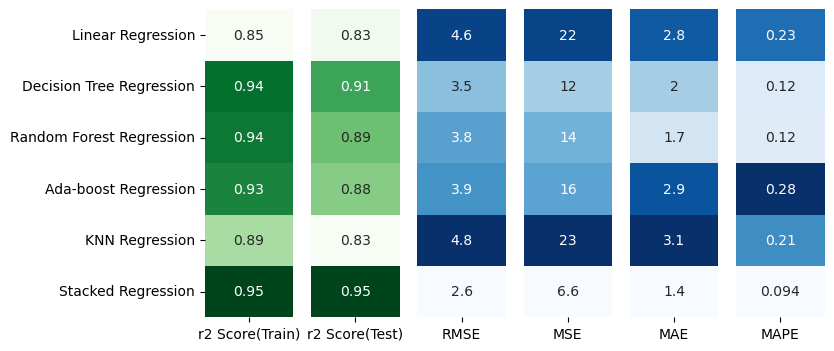

In [110]:
fig,ax=plt.subplots(1,6,figsize=(8,4))

sns.heatmap(final_results[["r2 Score(Train)"]],annot=True,yticklabels=model_list,ax=ax[0],cbar=False,cmap="Greens")
sns.heatmap(final_results[["r2 Score(Test)"]],annot=True,ax=ax[1],yticklabels=False,cbar=False,cmap="Greens")
sns.heatmap(final_results[["RMSE"]],annot=True,ax=ax[2],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MSE"]],annot=True,ax=ax[3],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MAE"]],annot=True,ax=ax[4],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MAPE"]],annot=True,ax=ax[5],yticklabels=False,cbar=False,cmap="Blues")

plt.show()

In [112]:
lin_score=average_adjusted_r2_score_test
dt_score=cross_val_score(dt_model,X,y3,scoring="r2",cv=kf)
rf_score=cross_val_score(rf_model,X,y3,scoring="r2",cv=kf)
ada_score=cross_val_score(ada_model,X,y3,scoring="r2",cv=kf)
knn_score=cross_val_score(knn_model,X,y3,scoring="r2",cv=kf)
stack_score=cross_val_score(stack_model,X,y3,scoring="r2",cv=kf)

all_scores=[lin_score,dt_score,rf_score,ada_score,knn_score,stack_score]

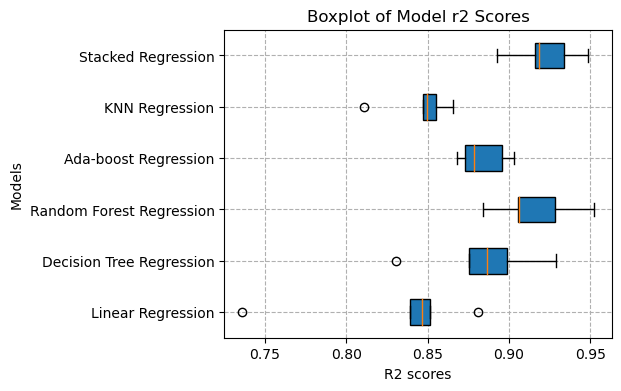

In [113]:
plt.figure(figsize=(5,4))
plt.boxplot(all_scores,labels=model_list,vert=False,patch_artist=True)
plt.title("Boxplot of Model r2 Scores")
plt.xlabel("R2 scores")
plt.ylabel("Models")
plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', linestyle='--')
plt.show()

## ---------------------------------------------------Prediction for 5 years--------------------------------------------------

In [114]:
A=mf_data.drop(["returns_5yr"],axis=1)
y5=mf_data["returns_5yr"]

scaled_data=pd.DataFrame(StandardScaler().fit_transform(A),columns=A.columns)
scaled_data["returns_5yr"]=y5
X=scaled_data.drop("returns_5yr",axis=1)

In [115]:
r2_train=[]
r2_test=[]
rmse=[]
mse=[]
mae=[]
mape=[]

## Multi-Linear Regression

In [116]:
average_adjusted_r2_score_train=[]
average_adjusted_r2_score_test=[]
avg_rmse=[]
avg_mse=[]
avg_mae=[]
avg_mape=[]
for train_data,test_data in kf.split(scaled_data):
    train,test=scaled_data.iloc[train_data],scaled_data.iloc[test_data]
    x_train=train.drop(["returns_5yr"],axis=1)
    y_train=train["returns_5yr"]
    
    x_test=test.drop(["returns_5yr"],axis=1)
    y_test=test["returns_5yr"]
    
    lin_model=LinearRegression().fit(x_train,y_train)
    y_pred=lin_model.predict(x_test)
    
    print("Intercept:",lin_model.intercept_)
    print("slope:",lin_model.coef_)
    print()
    
    metrics_print(lin_model)
    
RMSE=np.mean(avg_rmse)  
MSE=np.mean(avg_mse) 
MAE=np.mean(avg_mae) 
MAPE=np.mean(avg_mape)
R2_TRAIN=np.mean(average_adjusted_r2_score_train)
R2_TEST=np.mean(average_adjusted_r2_score_test)

print("Average adjusted r2 score of train data on different K-Fold",R2_TRAIN)
print("Average adjusted r2 score of test data on different K-Fold",R2_TEST)
metrics()

Intercept: 9.449919349775678
slope: [-0.05117047 -0.0434083   0.13822338 -0.46380588  0.25024888 -0.07431837
 -0.03753923  0.47728962  0.35528008 -0.02917132 -0.40765335  0.42863466
  0.30073062  0.05695032 -0.28209156  2.26702928]

Model adjusted r2 score on training data : 0.5700740009303341
Model adjusted r2 score on test data : 0.5531341774310545

RMSE: 2.147803797266771
MSE: 4.613061151553561
MAE: 1.525439115138015
MAPE: 0.22741723502703373
----------------------------------------------------------------------------------------------------
Intercept: 9.49357008304491
slope: [ 0.01412797 -0.15218435  0.12237854 -0.42946172  0.08934852 -0.13055528
 -0.09102569  0.58168848  0.4083658   0.09860787 -0.5336475   0.49534245
  0.18087205 -0.01516223 -0.34910749  2.26703508]

Model adjusted r2 score on training data : 0.587945852069256
Model adjusted r2 score on test data : 0.4773557342823942

RMSE: 2.277376597440971
MSE: 5.186444166571815
MAE: 1.5759336667658388
MAPE: 0.2501462577824969
-

## Decision Tree Regression

In [117]:
x_train,x_test,y_train,y_test=train_test_split(X,y5,test_size=0.3,random_state=42)

In [385]:
param_grid={'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [240]:
dt=DecisionTreeRegressor()

In [210]:
grid_cv=GridSearchCV(dt,param_grid,scoring="r2",cv=kf)

In [211]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50])},
             scoring='r2')

In [212]:
grid_cv.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)

In [118]:
dt_model=DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20).fit(x_train,y_train)
y_pred=dt_model.predict(x_test)

In [119]:
metrics_print1(dt_model)

Model adjusted r2 score on training data : 0.7527136218609294
Model adjusted r2 score on test data: 0.5483226152821186

RMSE: 2.1323697287540573
MSE: 4.547000660106652
MAE: 1.3556627819813951
MAPE: 0.19427005692370308


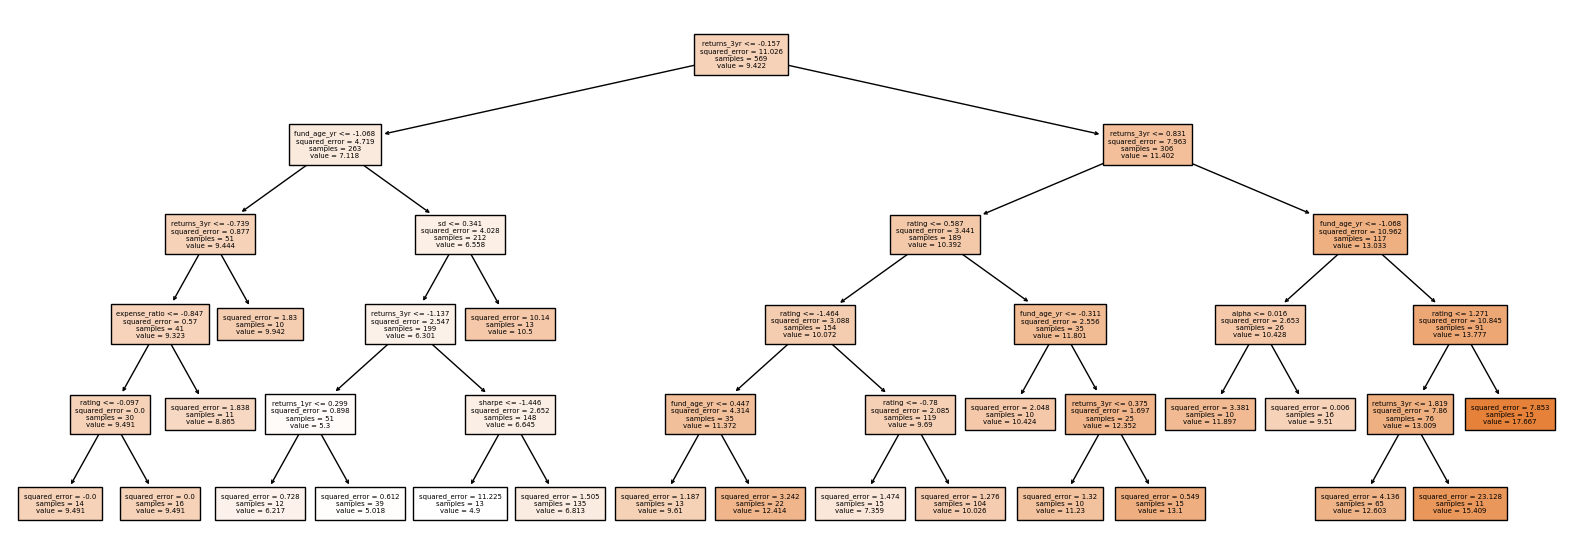

In [388]:
plt.figure(figsize=(20,7))
tree.plot_tree(dt_model,feature_names=X.columns,filled=True,fontsize=5)
plt.show()

## Random Forest Regression

In [389]:
param_grid={'n_estimators':np.arange(20,101,20),
           'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [390]:
rf=RandomForestRegressor()

In [391]:
grid_cv=GridSearchCV(rf,param_grid,scoring="r2",cv=kf)

In [219]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50]),
                         'n_estimators': array([ 20,  40,  60,  80, 100])},
             scoring='r2')

In [392]:
grid_cv.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [120]:
rf_model=RandomForestRegressor(max_depth=12, min_samples_leaf=10, min_samples_split=20,
                      n_estimators=60,random_state=42).fit(x_train,y_train)
y_pred=rf_model.predict(x_test)

In [121]:
metrics_print1(rf_model)

Model adjusted r2 score on training data : 0.8103822292680354
Model adjusted r2 score on test data: 0.6832574701747691

RMSE: 1.78567133109528
MSE: 3.1886221026955894
MAE: 1.1468131843289948
MAPE: 0.1669881069301245


## Adaboost Regression

In [396]:
param_grid={"n_estimators": np.arange(10,101,10),
           "learning_rate":np.arange(0.05,1,0.05)}

In [397]:
ada=AdaBoostRegressor()

In [398]:
grid_cv=GridSearchCV(ada,param_grid,scoring="r2",cv=kf)

In [226]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='r2')

In [227]:
grid_cv.best_estimator_

AdaBoostRegressor(learning_rate=0.6000000000000001, n_estimators=90)

In [122]:
ada_model=AdaBoostRegressor(learning_rate=0.6, n_estimators=90, random_state=42).fit(x_train,y_train)
y_pred=ada_model.predict(x_test)

In [123]:
metrics_print1(ada_model)

Model adjusted r2 score on training data : 0.7655283200258345
Model adjusted r2 score on test data: 0.557913857584411

RMSE: 2.1096081103389017
MSE: 4.450446379207672
MAE: 1.5572031303967269
MAPE: 0.21624748393539353


## K-Nearest Neighbour

In [401]:
r2_scores=[]
for k in range(2,25):
    knn_score=cross_val_score(KNeighborsRegressor(k),x_train,y_train,scoring="r2",cv=kf)
    r2_scores.append(np.mean(knn_score))

In [402]:
for k in range(2,25):
    print("number of neighbors:",k,":",r2_scores[k-2])

number of neighbors: 2 : 0.5113040717707926
number of neighbors: 3 : 0.5723036809343437
number of neighbors: 4 : 0.6076521232944065
number of neighbors: 5 : 0.5949463113247256
number of neighbors: 6 : 0.6089521735310177
number of neighbors: 7 : 0.6058916901984353
number of neighbors: 8 : 0.6012821088659118
number of neighbors: 9 : 0.5960617099134848
number of neighbors: 10 : 0.5973929712437306
number of neighbors: 11 : 0.5941663582130008
number of neighbors: 12 : 0.5921343079689713
number of neighbors: 13 : 0.5883489819300383
number of neighbors: 14 : 0.581503474945585
number of neighbors: 15 : 0.5770018352546085
number of neighbors: 16 : 0.5768238243009696
number of neighbors: 17 : 0.5764215863603394
number of neighbors: 18 : 0.5728808078761365
number of neighbors: 19 : 0.5693935937612877
number of neighbors: 20 : 0.5651601478482515
number of neighbors: 21 : 0.5639823562926642
number of neighbors: 22 : 0.5604209992894852
number of neighbors: 23 : 0.5583398983160506
number of neighbors

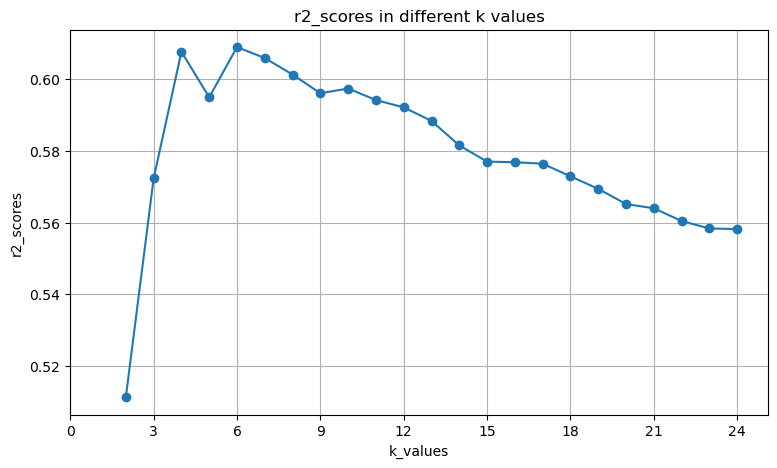

In [403]:
plt.figure(figsize=(9,5))
plt.plot(range(2,25),r2_scores,marker="o")
plt.ylabel("r2_scores")
plt.xlabel("k_values")
plt.title("r2_scores in different k values")
plt.xticks(range(0,25,3))
plt.grid()
plt.show()

In [124]:
k=4
knn_model=KNeighborsRegressor(k).fit(x_train,y_train)
y_pred=knn_model.predict(x_test)

In [125]:
metrics_print1(knn_model)

Model adjusted r2 score on training data : 0.7861435684704661
Model adjusted r2 score on test data: 0.5682102342268529

RMSE: 2.0848965361473595
MSE: 4.346793566439258
MAE: 1.4373679147083869
MAPE: 0.21193582099229394


## Stacked Regression

In [126]:
level1=[]
level1.append(("lr",LinearRegression()))
level1.append(("dt",DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)))
level1.append(("rf",RandomForestRegressor(max_depth=12, min_samples_leaf=10, min_samples_split=20,n_estimators=60,random_state=42)))
level1.append(("ada",AdaBoostRegressor(learning_rate=0.6, n_estimators=90, random_state=42)))
level1.append(("knn",KNeighborsRegressor(4)))
level1.append(("svr",SVR()))

level2=LinearRegression()

In [127]:
stack_model=StackingRegressor(estimators=level1,final_estimator=level2,cv=kf).fit(X,y5)
y_pred=stack_model.predict(x_test)

In [128]:
metrics_print1(stack_model)

Model adjusted r2 score on training data : 0.8507842780208064
Model adjusted r2 score on test data: 0.8321717319233637

RMSE: 1.2998130471009268
MSE: 1.6895139574137963
MAE: 0.8651163945978356
MAPE: 0.131449387852574


## ----------------------------------------- Best Model Selection for 5 years--------------------------------------------

In [129]:
model_list=["Linear Regression","Decision Tree Regression","Random Forest Regression","Ada-boost Regression","KNN Regression","Stacked Regression"]
metric_list=["Models","r2 Score(Train)","r2 Score(Test)","RMSE","MSE","MAE","MAPE"]

In [130]:
final_results=pd.DataFrame()
for i in range(0,len(model_list)):
    x=[[model_list[i],r2_train[i],r2_test[i],rmse[i],mse[i],mae[i],mape[i]]]
    new=pd.DataFrame(x)
    final_results=pd.concat([final_results,new],axis=0)
final_results.columns=metric_list
final_results=final_results.reset_index(drop=True)  
final_results

Models  r2 Score(Train)  r2 Score(Test)      RMSE  \
0         Linear Regression         0.578029        0.519964  2.171096   
1  Decision Tree Regression         0.752714        0.548323  2.132370   
2  Random Forest Regression         0.810382        0.683257  1.785671   
3      Ada-boost Regression         0.765528        0.557914  2.109608   
4            KNN Regression         0.786144        0.568210  2.084897   
5        Stacked Regression         0.850784        0.832172  1.299813   

        MSE       MAE      MAPE  
0  4.717820  1.575602  0.214582  
1  4.547001  1.355663  0.194270  
2  3.188622  1.146813  0.166988  
3  4.450446  1.557203  0.216247  
4  4.346794  1.437368  0.211936  
5  1.689514  0.865116  0.131449

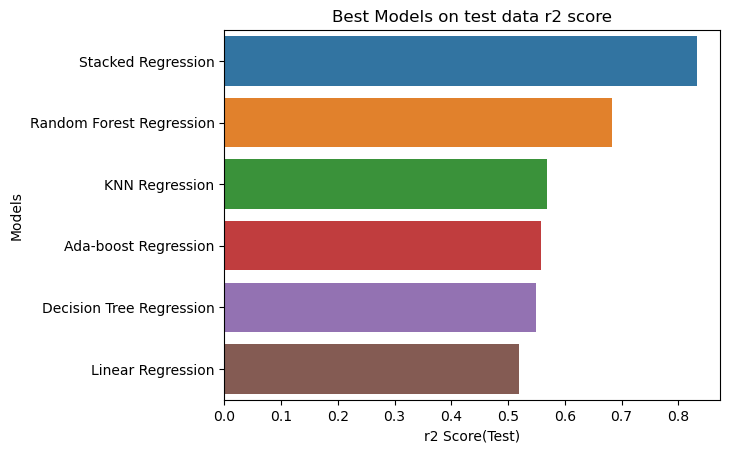

In [131]:
results=final_results.sort_values("r2 Score(Test)",ascending=False)
sns.barplot(x="r2 Score(Test)",y="Models",data=results)
plt.title("Best Models on test data r2 score")
plt.show()

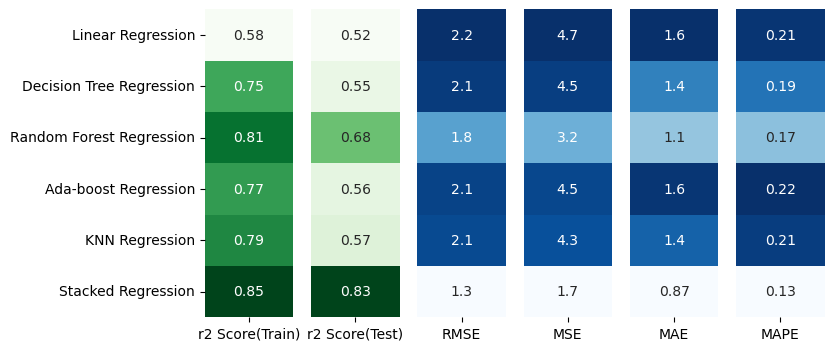

In [133]:
fig,ax=plt.subplots(1,6,figsize=(8,4))

sns.heatmap(final_results[["r2 Score(Train)"]],annot=True,yticklabels=model_list,ax=ax[0],cbar=False,cmap="Greens")
sns.heatmap(final_results[["r2 Score(Test)"]],annot=True,ax=ax[1],yticklabels=False,cbar=False,cmap="Greens")
sns.heatmap(final_results[["RMSE"]],annot=True,ax=ax[2],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MSE"]],annot=True,ax=ax[3],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MAE"]],annot=True,ax=ax[4],yticklabels=False,cbar=False,cmap="Blues")
sns.heatmap(final_results[["MAPE"]],annot=True,ax=ax[5],yticklabels=False,cbar=False,cmap="Blues")

plt.show()

In [134]:
lin_score=average_adjusted_r2_score_test
dt_score=cross_val_score(dt_model,X,y5,scoring="r2",cv=kf)
rf_score=cross_val_score(rf_model,X,y5,scoring="r2",cv=kf)
ada_score=cross_val_score(ada_model,X,y5,scoring="r2",cv=kf)
knn_score=cross_val_score(knn_model,X,y5,scoring="r2",cv=kf)
stack_score=cross_val_score(stack_model,X,y5,scoring="r2",cv=kf)

all_scores=[lin_score,dt_score,rf_score,ada_score,knn_score,stack_score]

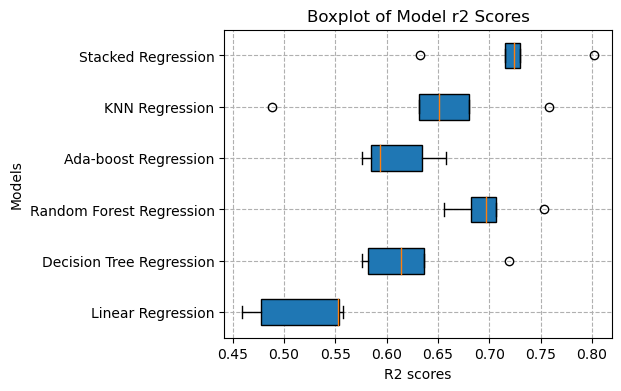

In [135]:
plt.figure(figsize=(5,4))
plt.boxplot(all_scores,labels=model_list,vert=False,patch_artist=True)
plt.title("Boxplot of Model r2 Scores")
plt.xlabel("R2 scores")
plt.ylabel("Models")
plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', linestyle='--')
plt.show()